**Fronteiras Teóricas e mapa de regimes**

# Importes de todas as funções


In [3]:
"""
gcm.maps
========
Mapa local biestável (linear por partes e ímpar) e utilidades analíticas.

Referência principal:
- Alvarez-Llamoza & Cosenza (2014), "Synchronization and phase ordering in globally
  coupled chaotic maps".

Este módulo define:
- f(x; mu): mapa local `bistable_map` (vetorizado).
- Rotinas auxiliares para intervalos biestáveis I_±, expoente de Lyapunov local
  e fronteiras analíticas (sincronização e escape).
"""

from __future__ import annotations

from typing import Tuple

import numpy as np

__all__ = ["_validate_mu",
    "bistable_map",
    "bistable_intervals",
    "lyapunov_local",
    "sync_boundaries",
    "escape_boundaries",
]


def _validate_mu(mu: float) -> None:
    """Valida o parâmetro mu em um domínio físico razoável.

    Não impomos o domínio estrito do paper aqui (mu em [-3, 3]),
    mas avisamos se mu==0, pois algumas fórmulas (p.ex. escape) o utilizam no denominador.
    """
    if not np.isfinite(mu):
        raise ValueError("mu deve ser finito.")
    if abs(mu) < 1e-15:
        raise ValueError("mu não pode ser zero (|mu| ~ 0), pois certas fórmulas dividem por mu.")


def bistable_map(x: np.ndarray, mu: float, *, out: np.ndarray | None = None) -> np.ndarray:
    """Aplica o mapa local biestável (linear por partes e ímpar).

    Definição (x ∈ [-1, 1]):
        f(x; mu) =
          - 2*mu/3 - mu*x,   se x ∈ [-1, -1/3]
            mu*x,            se x ∈ (-1/3,  1/3)
            2*mu/3 - mu*x,   se x ∈ [ 1/3,  1]

    Observações
    ----------
    - O mapa é ímpar: f(-x; mu) = -f(x; mu).
    - Em (1 < |mu| < 2), o sistema exibe caos e biestabilidade (dois atratores caóticos simétricos).
    - Esta função é vetorizada e não realiza "clipping" para [-1, 1]. O escape (|x|>1)
      deve ser detectado no nível do integrador/sistema.

    Parâmetros
    ----------
    x : np.ndarray
        Vetor/array com estado(s) em [-1, 1] idealmente.
    mu : float
        Parâmetro do mapa.
    out : np.ndarray, opcional
        Buffer de saída (mesmo shape de x), se desejado.

    Retorna
    -------
    np.ndarray
        f(x; mu) com mesmo shape que `x`.
    """
    _validate_mu(mu)
    x = np.asarray(x, dtype=float)
    y = x if out is None else out  # pode sobrescrever em buffer externo

    # Máscaras das faixas
    m_left = x <= -1.0 / 3.0
    m_mid = (x > -1.0 / 3.0) & (x < 1.0 / 3.0)
    m_right = x >= 1.0 / 3.0

    # Aplicação por partes (vetorizada)
    if y is x:
        y = np.empty_like(x, dtype=float)
    y[m_left] = -2.0 * mu / 3.0 - mu * x[m_left]
    y[m_mid] = mu * x[m_mid]
    y[m_right] = 2.0 * mu / 3.0 - mu * x[m_right]
    return y


def bistable_intervals(mu: float) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """Intervalos dos atratores caóticos I_- e I_+ para (1 < |mu| < 2).

    Fórmulas (para |mu| em (1, 2)):
        I_+ = [ mu*(2 - mu)/3 , mu/3 ]
        I_- = -I_+  = [ -mu/3 , -mu*(2 - mu)/3 ]

    Quando mu < 0, as expressões acima continuam válidas: I_+ terá limites com o mesmo sinal de mu.

    Parâmetros
    ----------
    mu : float
        Parâmetro local.

    Retorna
    -------
    ( (a_minus, b_minus), (a_plus, b_plus) ) : tupla de tuplas
        Intervalos I_- e I_+ (cada par ordenado a<=b).

    Levanta
    -------
    ValueError
        Se |mu| não pertencer ao regime biestável (1, 2).
    """
    _validate_mu(mu)
    if not (1.0 < abs(mu) < 2.0):
        raise ValueError("bistable_intervals: requer 1 < |mu| < 2 para biestabilidade.")

    a_plus = mu * (2.0 - mu) / 3.0
    b_plus = mu / 3.0
    a_minus = -b_plus
    b_minus = -a_plus

    # Ordena cada par para robustez (em caso de mu<0)
    i_minus = (min(a_minus, b_minus), max(a_minus, b_minus))
    i_plus = (min(a_plus, b_plus), max(a_plus, b_plus))
    return i_minus, i_plus


def lyapunov_local(mu: float) -> float:
    """Expoente de Lyapunov local do mapa por partes.

    Em regime linear por partes com derivada de módulo constante em cada ramo,
    temos λ_local = ln |mu| (para o mapa central e em regime caótico).

    Parâmetros
    ----------
    mu : float

    Retorna
    -------
    float
        λ_local = log(|mu|).
    """
    _validate_mu(mu)
    return float(np.log(abs(mu)))


def sync_boundaries(mu: float) -> tuple[float, float]:
    """Fronteiras analíticas de sincronização para o acoplamento global.

    Da análise linear do estado sincronizado:
        (1 - ε) * e^{λ_local} = ±1  ⇒  (1 - ε) * |mu| = ±1

    Assim:
        ε_sync_inf = 1 - 1/|mu|
        ε_sync_sup = 1 + 1/|mu|

    Parâmetros
    ----------
    mu : float

    Retorna
    -------
    (ε_sync_inf, ε_sync_sup) : tuple[float, float]
        Limites inferior e superior (o superior pode ultrapassar 1).
    """
    _validate_mu(mu)
    inv = 1.0 / abs(mu)
    return 1.0 - inv, 1.0 + inv


def escape_boundaries(mu: float) -> tuple[float, float]:
    """Fronteiras de escape aproximadas via (1 - ε) * mu = ±3.

    A condição de escape (fora de [-1, 1]) deriva das quebras de linearidade:
        (1 - ε) * mu = +3  ⇒  ε = 1 - 3/mu
        (1 - ε) * mu = -3  ⇒  ε = 1 + 3/mu

    Parâmetros
    ----------
    mu : float

    Retorna
    -------
    (ε_esc_low, ε_esc_high) : tuple[float, float]
        Dois valores ordenados (menor, maior). Podem estar fora de [0, 1].

    Observação
    ----------
    São fronteiras analíticas de referência; na prática, a ocorrência de escape
    depende do estado visitado e do regime de parâmetros.
    """
    _validate_mu(mu)
    eps1 = 1.0 - 3.0 / mu
    eps2 = 1.0 + 3.0 / mu
    eps_low, eps_high = (min(eps1, eps2), max(eps1, eps2))
    return float(eps_low), float(eps_high)



In [4]:
"""
gcm.core
========
Motor de evolução para mapas caóticos globalmente acoplados.

Atualização:
    x_i(t+1) = (1 - eps) * f(x_i(t); mu) + (eps / N) * sum_j f(x_j(t); mu)

Escolhas de projeto:
- API clara com `Config` imutável (dataclass frozen).
- Estado `x` em float64 para estabilidade numérica.
- `reset` com modos de ICs (meio-a-meio em I_± ou uniforme em [-1,1]).
- `step` e `run` vetorizados. `run` pode retornar a trajetória (track=True).
"""

from __future__ import annotations

from dataclasses import dataclass
from typing import Literal, Optional

import numpy as np


__all__ = ["Config", "GloballyCoupledMaps"]


@dataclass(frozen=True)
class Config:
    """Configuração imutável do sistema globalmente acoplado.

    Parâmetros
    ----------
    N : int
        Número de mapas (tamanho do sistema).
    eps : float
        Acoplamento global ε.
    mu : float
        Parâmetro local do mapa.
    seed : int | None, padrão None
        Semente para reprodutibilidade (usada em `reset`).
    """

    N: int
    eps: float
    mu: float
    seed: Optional[int] = None

    def __post_init__(self) -> None:
        if self.N <= 0:
            raise ValueError("N deve ser positivo.")
        if not np.isfinite(self.eps):
            raise ValueError("eps deve ser finito.")
        _validate_mu(self.mu)


class GloballyCoupledMaps:
    """Sistema de mapas globalmente acoplados.

    Métodos principais
    ------------------
    - reset(init): inicializa o estado `x`.
    - step(): executa 1 passo de tempo.
    - run(T, discard, track): executa T passos, com descarte opcional do transiente.

    Atributos
    ---------
    cfg : Config
        Configuração imutável do sistema.
    rng : np.random.Generator
        Gerador pseudoaleatório para ICs.
    x : np.ndarray, shape (N,)
        Estado atual do sistema.
    last_escaped_mask : np.ndarray[bool] | None
        Máscara de escape detectada no último `step` (|x| > 1). None antes do primeiro passo.
    """

    def __init__(self, cfg: Config):
        self.cfg = cfg
        self.rng = np.random.default_rng(cfg.seed)
        self.x = np.zeros(cfg.N, dtype=float)
        self.last_escaped_mask: np.ndarray | None = None

    # ------------------------ inicialização / ICs ------------------------ #

    def reset(
        self,
        init: Literal["half_half", "uniform"] = "half_half",
        rng: np.random.Generator | None = None,
    ) -> None:
        """Reinicializa o estado `x` de acordo com o modo escolhido.

        Parâmetros
        ----------
        init : {"half_half", "uniform"}, padrão "half_half"
            - "half_half": amostra metade dos índices em I_+ e metade em I_-, com
              valores uniformes em cada intervalo e indices embaralhados.
              Requer 1 < |mu| < 2 (regime biestável) para que I_± existam.
            - "uniform": amostra uniforme em [-1, 1] (modo de depuração).
        rng : np.random.Generator, opcional
            Gerador a ser usado; por padrão utiliza `self.rng`.
        """
        _rng = self.rng if rng is None else rng
        N = self.cfg.N
        mu = self.cfg.mu

        if init == "uniform":
            self.x = _rng.uniform(-1.0, 1.0, size=N)
            self.last_escaped_mask = None
            return

        if init != "half_half":
            raise ValueError('init deve ser "half_half" ou "uniform".')

        # I_± apenas no regime biestável
        i_minus, i_plus = bistable_intervals(mu)  # pode levantar ValueError se fora do regime
        half = N // 2
        rest = N - half

        x_plus = _rng.uniform(i_plus[0], i_plus[1], size=half)
        x_minus = _rng.uniform(i_minus[0], i_minus[1], size=rest)
        x = np.concatenate([x_plus, x_minus])
        _rng.shuffle(x)
        self.x = x.astype(float, copy=False)
        self.last_escaped_mask = None

    # ----------------------------- dinâmica ----------------------------- #

    def step(self) -> None:
        """Executa um passo de tempo.

        Aplica y = f(x; mu) de forma vetorizada, calcula a média e atualiza:
            x <- (1 - eps) * y + eps * mean(y)

        Também atualiza `last_escaped_mask` (True onde |x| > 1 após o passo).
        """
        y = bistable_map(self.x, self.cfg.mu)
        mean_y = float(y.mean())
        self.x = (1.0 - self.cfg.eps) * y + self.cfg.eps * mean_y
        self.last_escaped_mask = np.abs(self.x) > 1.0

    def run(
        self,
        T: int,
        discard: int = 0,
        *,
        track: bool = False,
    ) -> np.ndarray | None:
        """Roda T passos de tempo.

        Parâmetros
        ----------
        T : int
            Número total de passos.
        discard : int, padrão 0
            Número de passos iniciais a descartar (transiente), caso `track=True`.
        track : bool, padrão False
            Se True, retorna a trajetória como array (T - discard, N). Caso False, retorna None.

        Retorna
        -------
        np.ndarray | None
            Trajetória (T - discard, N) se `track=True`; caso contrário None.

        Notas
        -----
        - Mesmo com track=False, `last_escaped_mask` é atualizado a cada `step`.
        - Este método não calcula métricas; use `gcm.metrics` para isso.
        """
        if T <= 0:
            raise ValueError("T deve ser positivo.")
        if discard < 0 or discard >= T:
            if track:
                raise ValueError("discard deve estar em [0, T-1] quando track=True.")

        if track:
            traj = np.empty((T, self.cfg.N), dtype=float)
            for t in range(T):
                self.step()
                traj[t] = self.x
            return traj[discard:]
        else:
            for _ in range(T):
                self.step()
            return None



In [5]:
"""
gcm.metrics
===========
Métricas e estatísticas: sigma (sincronização), spins, magnetização,
parâmetro de ordem |<M>| e curva de persistência p_t.
"""

from __future__ import annotations

import numpy as np

__all__ = [
    "sigma",
    "spins",
    "magnetization",
    "order_param_M",
    "persistence_curve",
    "sigma_mean",
]


def sigma(x: np.ndarray) -> float:
    """Desvio-padrão instantâneo entre mapas.

    Parâmetros
    ----------
    x : np.ndarray, shape (N,)
        Estado no instante.

    Retorna
    -------
    float
        σ_t = std(x).
    """
    x = np.asarray(x, dtype=float)
    return float(np.std(x))


def spins(x: np.ndarray) -> np.ndarray:
    """Converte estado em spins s_i ∈ {-1, +1}.

    Convenção: valores exatamente 0 recebem +1.

    Parâmetros
    ----------
    x : np.ndarray, shape (N,)

    Retorna
    -------
    np.ndarray, shape (N,), dtype=int
        Vetor de spins.
    """
    x = np.asarray(x, dtype=float)
    s = np.ones_like(x, dtype=int)
    s[x < 0.0] = -1
    return s


def magnetization(x: np.ndarray) -> float:
    """Magnetização instantânea M_t = (1/N) * sum_i s_i.

    Parâmetros
    ----------
    x : np.ndarray, shape (N,)

    Retorna
    -------
    float
        Magnetização no instante.
    """
    s = spins(x)
    return float(np.mean(s))


def order_param_M(series_M: np.ndarray) -> float:
    """Parâmetro de ordem |<M>| (módulo da média temporal da magnetização).

    Parâmetros
    ----------
    series_M : np.ndarray, shape (T,)
        Série temporal de magnetização.

    Retorna
    -------
    float
        |<M>| = | mean(series_M) |.
    """
    series_M = np.asarray(series_M, dtype=float)
    return float(abs(series_M.mean()))


def persistence_curve(spin_series: np.ndarray) -> np.ndarray:
    """Curva de persistência p_t: fração que nunca mudou de sinal desde t=0.

    Implementação eficiente sem alocar matrizes gigantes:
    - Mantém um booleano `changed` por sítio.
    - Em cada t, atualiza `changed |= (s_t != s_0)` e computa p_t = mean(~changed).

    Parâmetros
    ----------
    spin_series : np.ndarray, shape (T, N), dtype=int
        Série de spins no tempo.

    Retorna
    -------
    np.ndarray, shape (T,)
        Vetor p_t.
    """
    S = np.asarray(spin_series)
    if S.ndim != 2:
        raise ValueError("spin_series deve ter shape (T, N).")

    T, N = S.shape
    s0 = S[0]
    changed = np.zeros(N, dtype=bool)
    p = np.empty(T, dtype=float)
    p[0] = 1.0  # no t=0 ninguém mudou

    for t in range(1, T):
        changed |= (S[t] != s0)
        p[t] = 1.0 - changed.mean()

    return p


def sigma_mean(sigmas: np.ndarray) -> float:
    """Média temporal de σ_t (após descarte já aplicado pelo chamador).

    Parâmetros
    ----------
    sigmas : np.ndarray, shape (T_meas,)

    Retorna
    -------
    float
        <σ> = mean(sigmas)
    """
    sigmas = np.asarray(sigmas, dtype=float)
    return float(sigmas.mean())



In [6]:
"""
gcm.analysis
============
Pipelines reprodutíveis para varreduras em ε, comparação com fronteiras analíticas,
salvamento de CSVs e geração de figuras.

Foco da Semana 1:
- Reproduzir/verificar fronteiras de sincronização (teóricas) e detectar escape.
- Varredura 1D em ε para um μ fixo (ex.: μ = 1.9), medindo <σ>.

Observação: as funções aqui NÃO escondem o custo computacional. Parâmetros como
T_burn e T_meas devem ser ajustados conscientemente.
"""

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Any, Dict

import numpy as np
import matplotlib.pyplot as plt

__all__ = [
    "ScanResult",
    "theory_boundaries",
    "scan_eps",
    "save_scan_to_csv",
    "plot_sigma_vs_eps",
]


@dataclass
class ScanResult:
    """Resultado de uma varredura 1D em ε para μ fixo.

    Atributos
    ---------
    mu : float
    eps_grid : np.ndarray, shape (K,)
    sigma_mean : np.ndarray, shape (K,)
        Média temporal de σ_t após burn-in.
    escaped_frac : np.ndarray, shape (K,)
        Fração de passos (no período de medição) em que ocorreu escape (|x|>1)
        em pelo menos um sítio. Útil como indicador de regime turbulento/escape.
    is_synced : np.ndarray, shape (K,), dtype=bool
        Marcador de sincronização via limiar numérico (σ̄ < tol_sync).
    meta : dict
        Metadados do experimento (N, T_burn, T_meas, seed_base, init, tol_sync).
    """

    mu: float
    eps_grid: np.ndarray
    sigma_mean: np.ndarray
    escaped_frac: np.ndarray
    is_synced: np.ndarray
    meta: Dict[str, Any]


def theory_boundaries(mu: float) -> dict:
    """Coleta as fronteiras teóricas úteis para sobreposição em gráficos.

    Parâmetros
    ----------
    mu : float

    Retorna
    -------
    dict
        {
          "mu": mu,
          "eps_sync": (eps_sync_inf, eps_sync_sup),
          "eps_escape": (eps_esc_low, eps_esc_high),
        }
    """
    eps_sync = sync_boundaries(mu)
    eps_esc = escape_boundaries(mu)
    return {"mu": mu, "eps_sync": eps_sync, "eps_escape": eps_esc}


def _ensure_parent(path: Path) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)


def scan_eps(
    mu: float,
    eps_grid: np.ndarray,
    N: int,
    *,
    T_burn: int = 2_000,
    T_meas: int = 2_000,
    init: str = "half_half",
    seed_base: int | None = 12345,
    tol_sync: float = 1e-7,
) -> ScanResult:
    """Varre ε e mede <σ>, escape e sincronização para μ fixo.

    Procedimento (para cada ε):
    - Cria sistema GCM(N, ε, μ).
    - reset(init="half_half") (exige 1 < |μ| < 2) ou "uniform".
    - Roda T_burn passos sem registrar.
    - Roda T_meas passos medindo σ_t e se houve escape.
    - σ̄ = mean(σ_t); marcamos `is_synced = (σ̄ < tol_sync)`.

    Parâmetros
    ----------
    mu : float
    eps_grid : np.ndarray, shape (K,)
        Valores de ε a varrer.
    N : int
        Tamanho do sistema.
    T_burn : int, padrão 2000
        Passos de transiente a descartar.
    T_meas : int, padrão 2000
        Passos de medição.
    init : {"half_half", "uniform"}, padrão "half_half"
        Modo de ICs.
    seed_base : int | None, padrão 12345
        Semente base; variamos por índice de ε para reprodutibilidade.
    tol_sync : float, padrão 1e-7
        Limiar para marcar sincronização via σ̄.

    Retorna
    -------
    ScanResult
        Estrutura com arrays por ε e metadados.
    """
    eps_grid = np.asarray(eps_grid, dtype=float)
    K = eps_grid.size

    sigma_mean_arr = np.empty(K, dtype=float)
    escaped_frac_arr = np.empty(K, dtype=float)
    is_synced_arr = np.empty(K, dtype=bool)

    for k, eps in enumerate(eps_grid):
        seed = None if seed_base is None else (int(seed_base) + k)
        cfg = Config(N=N, eps=float(eps), mu=float(mu), seed=seed)
        sys = GloballyCoupledMaps(cfg)
        sys.reset(init="half_half" if init == "half_half" else "uniform")

        # Burn-in
        sys.run(T_burn, track=False)

        # Medição
        escaped_count = 0
        sigmas = np.empty(T_meas, dtype=float)
        for t in range(T_meas):
            sys.step()
            sigmas[t] = sigma(sys.x)
            if sys.last_escaped_mask is not None and sys.last_escaped_mask.any():
                escaped_count += 1

        sigma_mean_arr[k] = float(sigmas.mean())
        escaped_frac_arr[k] = escaped_count / float(T_meas)
        is_synced_arr[k] = sigma_mean_arr[k] < tol_sync

    meta = dict(
        N=N,
        T_burn=T_burn,
        T_meas=T_meas,
        init=init,
        seed_base=seed_base,
        tol_sync=tol_sync,
    )
    return ScanResult(
        mu=float(mu),
        eps_grid=eps_grid,
        sigma_mean=sigma_mean_arr,
        escaped_frac=escaped_frac_arr,
        is_synced=is_synced_arr,
        meta=meta,
    )


def save_scan_to_csv(result: ScanResult, path: str | Path) -> Path:
    """Salva o resultado de `scan_eps` em CSV com colunas amigáveis.

    Colunas:
      eps, sigma_mean, escaped_frac, is_synced (0/1), mu, N, T_burn, T_meas, init, seed_base, tol_sync

    Parâmetros
    ----------
    result : ScanResult
    path : str | Path
        Caminho do CSV (será criado; diretórios pais serão gerados).

    Retorna
    -------
    Path
        Caminho final salvo.
    """
    path = Path(path)
    _ensure_parent(path)
    data = np.column_stack(
        [
            result.eps_grid,
            result.sigma_mean,
            result.escaped_frac,
            result.is_synced.astype(int),
        ]
    )
    header = (
        "eps,sigma_mean,escaped_frac,is_synced,"
        f"mu,N,T_burn,T_meas,init,seed_base,tol_sync\n"
    )
    # Cabeçalho de metadados na primeira linha + dados
    meta = result.meta
    meta_line = (
        f"# mu={result.mu}, N={meta['N']}, T_burn={meta['T_burn']}, T_meas={meta['T_meas']}, "
        f"init={meta['init']}, seed_base={meta['seed_base']}, tol_sync={meta['tol_sync']}\n"
    )
    with path.open("w", encoding="utf-8") as f:
        f.write(meta_line)
        f.write(header)
        np.savetxt(f, data, delimiter=",", fmt="%.10g")
    return path


def plot_sigma_vs_eps(
    result: ScanResult,
    *,
    outpath: str | Path | None = None,
    show: bool = False,
) -> Path | None:
    """Gera o gráfico σ̄(ε) com linhas verticais nas fronteiras teóricas.

    Parâmetros
    ----------
    result : ScanResult
    outpath : str | Path | None, padrão None
        Se fornecido, salva a figura em `outpath`. Diretórios pais serão criados.
    show : bool, padrão False
        Se True, exibe a figura (bloqueante em alguns ambientes locais).

    Retorna
    -------
    Path | None
        Caminho salvo, se `outpath` não for None.
    """
    bounds = theory_boundaries(result.mu)
    eps_sync_inf, eps_sync_sup = bounds["eps_sync"]
    eps_esc_low, eps_esc_high = bounds["eps_escape"]

    fig, ax = plt.subplots(figsize=(7.5, 4.5))
    ax.plot(result.eps_grid, result.sigma_mean, marker="o", lw=1.5, ms=4, label=r"$\overline{\sigma}$")
    ax.set_xlabel(r"$\varepsilon$")
    ax.set_ylabel(r"$\overline{\sigma}$")
    ax.grid(True, alpha=0.25)

    # Linhas de referência (sincronização e escape)
    for x, ls, lab in [
        (eps_sync_inf, "--", "sync (inf)"),
        (eps_sync_sup, "--", "sync (sup)"),
        (eps_esc_low, ":", "escape (low)"),
        (eps_esc_high, ":", "escape (high)"),
    ]:
        if np.isfinite(x):
            ax.axvline(x, linestyle=ls, alpha=0.7, label=lab)

    ax.legend(loc="best", frameon=True)

    saved_path: Path | None = None
    if outpath is not None:
        saved_path = Path(outpath)
        _ensure_parent(saved_path)
        fig.tight_layout()
        fig.savefig(saved_path, dpi=200)
    if show:
        plt.show()
    plt.close(fig)
    return saved_path



# Fig. 1 - Toeria (fronteiras) e mapa de regimes ($\mu$ x $ϵ$)

Objetivo: Reproduzir geometria teórica das fronteiras de **sincronização** e **escape** no plano ($\mu$, $ϵ$) - Figura 1 do artigo, cin:
- Fronteiras de **sincronização** (banda entre curvas),
- **Escape** (curvas tracejadas)
- Divisão entre região sincronizada caótica e estacionária

## Introdução e motivação

> Artigo: [arXiv:1402.4870](https://arxiv.org/pdf/1402.4870)

O objetivo do artigo é verificar o efeito de inserirmos uma **interação global** na evolução do sistema

Pense na seguinte analogia: 

Diferente do ising local que vimos ao longo do curso (troca de spin afetada apenas pelos primeiros vizinhos), queremos observar como o efeito de um spin sentir uma média global do sistema afeta sua evolução ao longo do tempo.

Uma boa analogia da vida real que poemos fazer é a seguinte: Imagine que estamos vendo opiniões/canais que cada casa escolhe ver em um páis. Além disso, existe um jornal global que diz a média de opiniões/canais de todo mundo. 

A opinião/canal assistido de cada casa é influenciada tanto pelos seus vizinhos quanto pela média global (opinião de todas as casas). 

A modelagem matemática feita pelo artigo e que iremos seguir ao longo do notebook é a seguinte

Consideramos **N** mapas acoplados globalmente:

$$\boxed{x_i^{t+1} = (1-\varepsilon)f(x_i^{t}, \mu) + \frac{\varepsilon}{N}\sum_{j=1}^{N} f(x_j^{t}, \mu),\quad i=1,\dots,N}$$

Imaginei que cada $x^{i}$ é um spin/ opinião de uma casa em específico e sua evolução é determinada por um mapa local $f(x_j, \mu)$ e uma média global, cuja influência é determinada pelo peso da variável $\varepsilon$.

Logo $\varepsilon$ mais próximo de 1, maior o peso da influência global (valores maiores fazem o mapa local ter mais influência).

Abaixo vamos entender o comportamento das fronteiras


## Imports, utilidades e paths

In [7]:
## Imports, utilidades e paths

import json,os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Usamos diretamente as funções do pacote
import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

# Saídas
FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

# Domínio "igual ao artigo"
MU_MIN, MU_MAX = -3.0, 3.0
EPS_MIN, EPS_MAX = -1, 3    # faixa vertical ampla para visualizar tudo com conforto

mu_grid = np.linspace(MU_MIN, MU_MAX, 1201)

# Paleta (tons suaves para enxergar sobreposições)
COL_BG_NON_SYNC  = "#e09f3e"  # não sincronizado (Honey Bronze)
COL_SYNC_STAT    = "#335c67"  # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS   = "#9fd356"  # síncrono caótico (Yellow Green)
COL_ESCAPE       = "#9e2a2b"  # escape (Brown Red)

# Cores das linhas
COL_SYNC_LINE    = "black"  # linhas de sincronização (verde-escuro)
COL_ESC_LINE     = "#b22222"  # linhas de escape (vermelho-escuro)

def arrays_from_boundaries(mu_vec):
    """Gera arrays (eps_sync_inf, eps_sync_sup, eps_esc_lo, eps_esc_hi) ao longo de mu_vec."""
    s_inf = np.empty_like(mu_vec, dtype=float)
    s_sup = np.empty_like(mu_vec, dtype=float)
    e_lo  = np.empty_like(mu_vec, dtype=float)
    e_hi  = np.empty_like(mu_vec, dtype=float)

    for i, mu in enumerate(mu_vec):
        if abs(mu) < 1e-12:
            s_inf[i] = np.nan; s_sup[i] = np.nan
            e_lo[i]  = np.nan; e_hi[i]  = np.nan
            continue
        si, ss = sync_boundaries(mu)      # usa gcm.maps
        el, eh = escape_boundaries(mu)    # usa gcm.maps
        s_inf[i], s_sup[i] = si, ss
        e_lo[i],  e_hi[i]  = el, eh
    return s_inf, s_sup, e_lo, e_hi


## Curvas teóricas com sombreamento por regiões

Figura salva em: figs/FIG1_mu_eps_teoria_annot.png


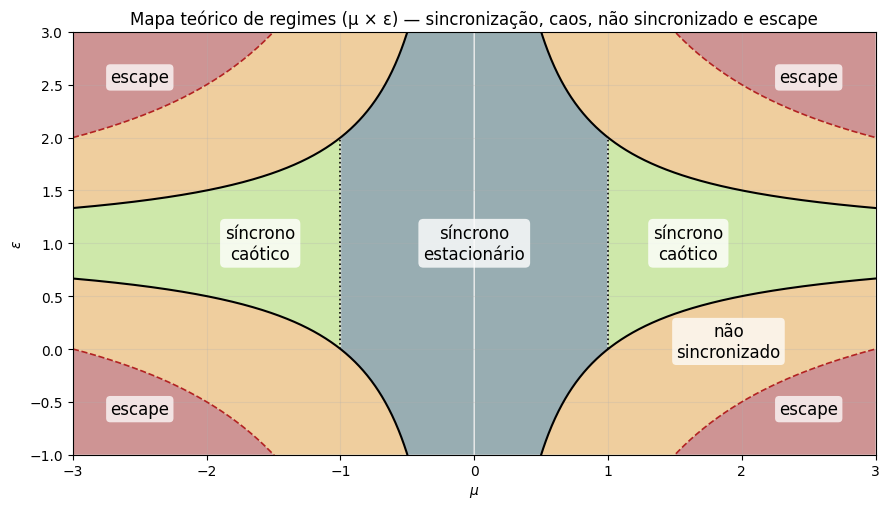

In [8]:
sync_inf, sync_sup, esc_lo, esc_hi = arrays_from_boundaries(mu_grid)

# Clipping para o retângulo de interesse (evita problemas de ±inf/NaN nos fills)
def clip(a): return np.clip(a, EPS_MIN, EPS_MAX)
c_sync_inf, c_sync_sup = clip(sync_inf), clip(sync_sup)
c_esc_lo,  c_esc_hi    = clip(esc_lo),  clip(esc_hi)

valid_sync = np.isfinite(sync_inf) & np.isfinite(sync_sup)
valid_esc  = np.isfinite(esc_lo)  & np.isfinite(esc_hi)

mask_stat  = (np.abs(mu_grid) <  1.0)
mask_chaos = (np.abs(mu_grid) >= 1.0)

fig, ax = plt.subplots(figsize=(9, 5.2))
ax.set_facecolor("#FFFFFF")

# --- ESCAPE (vermelho-claro), acima e abaixo das curvas tracejadas ---
# abaixo
ax.fill_between(mu_grid, EPS_MIN, c_esc_lo, where=valid_esc, color=COL_ESCAPE, alpha=0.5, linewidth=0)
# acima
ax.fill_between(mu_grid, c_esc_hi, EPS_MAX, where=valid_esc, color=COL_ESCAPE, alpha=0.5, linewidth=0)


# ---------------- NÃO SINCRONIZADO ---------------- #
# Definição: entre ESCAPE e a banda de SINCRONIZAÇÃO
# parte inferior: esc_lo → sync_inf
mask_ns_lower = valid_esc & valid_sync & (c_esc_lo < c_sync_inf)
ax.fill_between(
    mu_grid, c_esc_lo, c_sync_inf,
    where=mask_ns_lower, color=COL_BG_NON_SYNC, alpha=0.5, linewidth=0,)
# parte superior: sync_sup → esc_hi
mask_ns_upper = valid_esc & valid_sync & (c_sync_sup < c_esc_hi)
ax.fill_between(
    mu_grid, c_sync_sup, c_esc_hi,
    where=mask_ns_upper, color=COL_BG_NON_SYNC, alpha=0.5, linewidth=0)


# --- REGIÃO SINCRONIZADA ---
# Síncrono estacionário: |μ|<1  
ax.fill_between(mu_grid, c_sync_inf, c_sync_sup,
                where=valid_sync & mask_stat,
                color=COL_SYNC_STAT, alpha=0.5, linewidth=0)
# Síncrono caótico: |μ|≥1  
ax.fill_between(mu_grid, c_sync_inf, c_sync_sup,
                where=valid_sync & mask_chaos,
                color=COL_SYNC_CHAOS, alpha=0.5, linewidth=0)

# --- LINHAS DE REFERÊNCIA ---
# Fronteiras de sincronização (sólidas)
ax.plot(mu_grid, sync_inf, color=COL_SYNC_LINE, lw=1.5)
ax.plot(mu_grid, sync_sup, color=COL_SYNC_LINE, lw=1.5)

# Fronteiras de escape (tracejadas, vermelho-escuro)
ax.plot(mu_grid, esc_lo, color=COL_ESC_LINE, lw=1.2, ls="--")
ax.plot(mu_grid, esc_hi, color=COL_ESC_LINE, lw=1.2, ls="--")

# Linhas verticais μ = -1 e μ = 1 (pontilhadas, pretas finas)
def vsegment_inside_sync(mu0: float):
    si, ss = sync_boundaries(mu0)
    if not (np.isfinite(si) and np.isfinite(ss)):
        return
    si, ss = float(clip(si)), float(clip(ss))
    if si < ss:  # só plota se fizer sentido
        ax.plot([mu0, mu0], [si, ss], color="k", lw=1.2, ls=":", zorder=5)

vsegment_inside_sync(-1.0)
vsegment_inside_sync( 1.0)


# --- RÓTULOS DENTRO DAS REGIÕES (sem legenda externa) ---
# posições "inteligentes" (escolhidas para evitar sobreposição)
def mid_sync(mu):
    si, ss = sync_boundaries(mu)
    y = 0.5*(si + ss)
    return float(np.clip(y, EPS_MIN+0.1, EPS_MAX-0.1))

# Síncrono estacionário (μ≈0)
ax.text(0.0, 1.0,
        "síncrono\nestacionário",
        ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))

# Síncrono caótico (lado + e lado −, simetria)
ax.text( 1.6, mid_sync(1.6),  "síncrono\ncaótico", ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))
ax.text(-1.6, mid_sync(1.6),  "síncrono\ncaótico", ha="center", va="center",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.3"))

# Não sincronizado (abaixo da banda de sync, em μ≈1.6)
si_16, _ = sync_boundaries(1.6)
ax.text(1.9, si_16 - 0.12,
        "não\nsincronizado",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))

# Escape (acima e abaixo)
el_22, eh_22 = escape_boundaries(2.2)
ax.text(2.5, min(EPS_MAX-0.1, eh_22 + 0.12),
        "escape",
        ha="center", va="bottom",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))
ax.text(2.5, max(EPS_MIN+0.1, el_22 - 0.12),
        "escape",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))

ax.text(-2.5, min(EPS_MAX-0.1, eh_22 + 0.12),
        "escape",
        ha="center", va="bottom",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))
ax.text(-2.5, max(EPS_MIN+0.1, el_22 - 0.12),
        "escape",
        ha="center", va="top",
        fontsize=12, color="black",
        bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", boxstyle="round,pad=0.25"))



# Eixos e limites
ax.set_xlim(MU_MIN, MU_MAX)
ax.set_ylim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Mapa teórico de regimes (μ × ε) — sincronização, caos, não sincronizado e escape")
ax.grid(alpha=0.25)
# sem legend() — os rótulos estão dentro das regiões

out = FIGS / "FIG1_mu_eps_teoria_annot.png"
fig.tight_layout(); fig.savefig(out, dpi=220); 
plt.show #plt.close(fig)
print("Figura salva em:", out)


## Teoria - De onde vêm as retas? (Resumo)

### 1) Banda de Sincronização

Observação: O mapa local é dado por


$$f(x;\mu) = \begin{cases}
-\tfrac{2\mu}{3} - \mu x, & x\in[-1,-\tfrac{1}{3}] \\
\mu x, & x\in[-\tfrac{1}{3},\tfrac{1}{3}] \\
\tfrac{2\mu}{3} - \mu x, & x\in[\tfrac{1}{3},1].
\end{cases}$$

Cuja derivada é: $f'(x) = \pm \mu$


A equação vetorizada do nossos N mapas é dada por:


$$x^{t+1} = [(1-\epsilon)\mathbb{I} +\frac{\epsilon}{N}M]f(x^{t})$$

Com a matriz M tendo dois autovalores, $m_k=N$ ou $m_k=0$ (degenerado (N-1)x). Os autovetores associados a $m_k=0$ são chamados de modos tranversos, eles são os modos que fazem com que os estados não estejam sincronizados. Para verificar isso imaginemos $f(x^{t})= \sum c_i v_i$, uma combinação dos autovetores. Substituindo na equação observamos que:

$$x^{t+1}= c_N v_N+\sum_{i=1}^{N-1}(1-\epsilon)c_i v_i$$

A sincronização irá ocorrer quando $x_i$ for igual para todo $i$. 
Pela equação acima notamos que a sincronização ocorre quando os modos transversos não existem, dessa forma as fronteiras de sincronização podem ser definidas observando quando os coeficientes desses módulos vão a 0, ou, em outras palavas, quando esses modos são suprimidos.

Consideremos agora que nosso mapa local, $f(x^{t})$ pode ser entendido como exponencial, de forma que $f'(x^{t}) = e^{\lambda}$, onde associaremos $\lambda$ ao expoente de Lyapnov do mapa local.

Derivando $f(x^{t})$ pela sua definição, observamos que $f'(x^{t})=\pm \mu$ de modo que $\lambda = ln(|\mu|)$ em geral.

Agora, vamos definir as fronteiras de sincronização observando apenas a equação para o conjunto de vetores do modo transverso, fazendo um pequeno desvio em $\delta x_t$, temos:

$$\delta x_{t+1} = (1-\varepsilon)\,f'(x_t)\,\delta x_t $$

Notamos agora que $\lambda_{\perp}$ pode ser definido a partir de $e^{\lambda_{\perp}}\equiv \frac{\delta x_{t+1}}{\delta x_t} $ pois estavamos vendo o quando a rota de x muda caso variemos a condição inicial um pouco. Desse modo chegamos a conclusão que:

$$e^{\lambda_{\perp}} =(1-\varepsilon) e^{\lambda}  \quad\Rightarrow\quad
\lambda_\perp = \ln|1-\varepsilon| + \lambda $$

Há **sincronização** se $\lambda_{\perp}<0$, pois será quando os modos transversos irão ser suprimidos com os passos, ou seja, com tempo longo o suficiente iremos extinguir os modos transversos e deixar apenas o modo N que naturalmente garante que o próximo passo seja igual ao anterior.

Dessa forma, nossa equação torna-se:

$$|(1-\varepsilon)\,e^{\lambda}|<1 \;\Longleftrightarrow\; |(1-\varepsilon)\mu| < 1$$

Note que utilizamos que $e^{\lambda}= \pm \mu$. Assim essas retas definem a fronteira teórica de sincronização e não sincronização com : $\varepsilon = 1 \pm \frac{1}{|\mu|}$, essas foram as equações utilizadas para definir esse regime.

Dentro desta banda, o sistema é sincronizado. Entretanto, ainda há dois tipos de sincronização: **Caótica** e **Estacionária**, como diferenciá-las?.

Para diferenciar a sincronização cáotica da estacionária devemos observar a equação do autovetor associado ao autovalor $m_k=N$. Observando esse autovetor, nossa equação torna-se:

$$\delta x_{t+1} =f'(x_t)\delta x_t \quad\Rightarrow\quad e^{\lambda} = |\mu|$$

Como já discutido. Dessa maneira, podemos diferenciar a sincronização caótica da estacionária quando $\lambda > 0$ (caótico) e $\lambda <0 $ (estacionário), esses regimes, normais para o expoente de Lyapnov, implicam $\mu = \pm 1$ portanto isso separa a fronteira sincronizada caótica da sincronizada estacionária. 

Importante ressaltar: Estar sincronizado significa que todos os mapas seguem a mesma rota após um número suficiente de passos, ou seja, os mapas mudam caóticamente se variamos a condição inicial, mas seguem o mesmo regime caótico: Aqui podemos observar que caoticidade não implica em aleatoridade.


### 2) Linhas de escape 

A linha de escape é definida simplesmente pelos valores de $\mu$ e $\epsilon$ que fazem com que $x^{t+1}$ se mantenha no invervalo $x \in [-1,1]$. Substituindo $x^{t}=\pm 1$ na equação de $x^{t+1}$ notamos que (considerando N grande) a condição para não ter escape pode ser aproximada por:

$$|(1-\varepsilon)\,\mu| < 3
\quad\Rightarrow\quad
(1-\varepsilon)\,\mu = \pm 3$$


Logo a curva $(1-\varepsilon)\,\mu = \pm 3$ define a fronteira entre o escape de $x$ dentro do invervalo desejado.

As regiões **acima** da curva superior e **abaixo** da inferior correspondem a **escape** (valores que chutam o sistema para fora de $[-1,1]$.


### 3) Região não sincronizada

É simplemente um complemento (dentro do gráfico) entre a banda sincronizada e a banda de escape há o regime chamado de turbulento, onde cada mapa segue caminhos aleatórios mesmo após um tempo bem longo.

### 4) Como podemos interpretar isso? (Fisicamente + Outra analogia)

#### a) Analogia física para ler o diagrama 

**Ferromagneto de campo médio**

* $x_i:$ "momento magnético efetivo" (variável local de um pseud-spin contínuo). O sinal de $x_i$ indica a "fase" (estado do tipo $I_+$ e $I_-$); o módulo vai nos dizer o quão "firme" está essa escolha (mais tarde vamos associar isso a magnetização média).
* $f(x;\mu)$: mapa local de um sítio em um passo de tempo -- Como resposta intrínseca do átomo magnético ao próprio estado/vizinhos.
* $\mu$: ganho/tendência local:
* * $|\mu|<1:$ resposta contrativa (vai ao ponto fixo).
  * $|\mu|>1$: caótica e biestável (dois atratores $I_{\pm}$).
* $\varepsilon:$ força de acoplamento de campo médio (todos com todos - mapa global).

O estado sincrono estacionário pode ser entendido da seguinte forma: o mapa local não altera a configuração. Todo os spins colapsam para o mesmo ponto fixo (trajetória comum e constante).

Já o estado síncrono caótico temos: Todos os spins possuem sempre o mesmo valor (estabilidade), mas o mapa local é caótico. Todos seguem a mesma órbita caótica, os spins variam juntos da mesma maneira, com a tendência global definida e previsível. 

A não sincronia é simplesmente dizer que o mapa global, ou melhor, o campo médio global não vence a expansão local: Cada spin segue sua própria trajetória sem todos irem para o mesmo caminho.


#### b) Analogia do cotidiano 

**Canais de TV e manchete nacional**

* $x_i:$ Pode ser interpretado como a tendência de certa casa i para algum canal de TV.
* $f(x;\mu)$: mapa local; como a casa atualiza a preferência de algum canal num dia, por conta própria ou considerando o que seus vizinhos veem.
* $\mu$: Reatividade da casa ao hábito de seus vizinhos ou ao seu próprio vizualizador:
* $\varepsilon:$ Força de uma manchete nacional (campo médio).Quanto maior, mais as casas seguem a tendência da maioria .

O estado sincrono estacionário pode ser entendido da seguinte forma: Todo mundo assiste ao mesmo canal, ao mesmo tempo o tempo todo, não há mudança e x fixa em um valor fixo.

Já o estado síncrono caótico temos: Nesse caso, a manchete nacional faz com que todos sigam o canal da manchete mas esse canal muda ao longo do tempo pois as casas reagem aos seus vizinhos, todo mundo muda de canal, mas de forma sincrona de modo que as casas trocam de canal caoticamente, mas da mesma forma.

A não sincronia é simplesmente dizer que o mapa global, ou melhor, a manchete nacional não possui influência o suficiente para fazer com que todos sigam o mesmo caminho, nesse caso cada casa pode ser mais guiada pelos seus vizinhos ou até mesmo por sua própria opinião ($\mu$).

In [9]:
payload = {
    "mu_grid": mu_grid.tolist(),
    "sync_inf": np.where(np.isfinite(sync_inf), sync_inf, None).tolist(),
    "sync_sup": np.where(np.isfinite(sync_sup), sync_sup, None).tolist(),
    "esc_lo":   np.where(np.isfinite(esc_lo),   esc_lo,   None).tolist(),
    "esc_hi":   np.where(np.isfinite(esc_hi),   esc_hi,   None).tolist(),
    "xlim": [float(MU_MIN), float(MU_MAX)],
    "ylim": [float(EPS_MIN), float(EPS_MAX)],
}
(DATA / "theory_bounds_mu_eps_full.json").write_text(json.dumps(payload), encoding="utf-8")
print("Curvas salvas em:", DATA / "theory_bounds_mu_eps_full.json")


Curvas salvas em: data/theory_bounds_mu_eps_full.json


# Explorador de um mapa - Observando diferentes regiões

## Imports & Setups

In [10]:
import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

# Imports do pacote do projeto

# Paleta (igual pedida)
COL_NON_SYNC  = "#e09f3e"   # não sincronizado
COL_SYNC_STAT = "#335c67"   # síncrono estacionário
COL_SYNC_CHAOS= "#9fd356"   # síncrono caótico
COL_ESCAPE    = "#9e2a2b"   # escape

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

MU_MAIN = 1.9     # μ do artigo (biestável e caótico local)
I_TRACKS = [0, 1, 2, 3]  # índices que vamos olhar nos exemplos com múltiplas trajetórias


def fprime_piecewise(x, mu):
    """f'(x;mu): μ no miolo (|x|<1/3), -μ nas abas (|x|≥1/3)."""
    x = np.asarray(x)
    return np.where(np.abs(x) < 1.0/3.0, mu, -mu)


def estimate_lambda_local(x_series, mu):
    """λ_est ≈ mean_t ln|f'(x_t)| (tempo finito). Para este mapa, ~ ln|μ|."""
    fp = fprime_piecewise(x_series, mu)
    return float(np.mean(np.log(np.abs(fp))))

def shade_Ipm(ax, mu, alpha=0.12):
    """Sombras das bandas I_- e I_+ quando 1<μ<2 (apoio visual)."""
    if 1.0 < abs(mu) < 2.0:
        (imin, imax), (jmin, jmax) = bistable_intervals(mu)
        ax.axhspan(imin, imax, alpha=alpha, color="k")
        ax.axhspan(jmin, jmax, alpha=alpha, color="k")


def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp

def run_custom_init(mu, eps, x0, T_burn=0, T_meas=400, seed=0):
    """Roda o sistema começando de um vetor x0 dado (bypass do reset). Retorna (traj, sys)."""
    cfg = Config(N=len(x0), eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.x = np.array(x0, dtype=float)
    if T_burn>0:
        sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys


def run_track_including_initial(cfg, init_kind="half_half", x0=None, T=400, seed=None):
    """
    Executa e retorna uma matriz (T+1, N) que INCLUI o estado inicial na linha 0.
    Se x0 for fornecido, usa-o diretamente; caso contrário, chama reset(init_kind).
    """
    sys = GloballyCoupledMaps(cfg)
    if x0 is None:
        sys.reset(init=init_kind)
    else:
        sys.x = np.array(x0, dtype=float)
    N = sys.x.size
    hist = np.empty((T+1, N), dtype=float)
    hist[0] = sys.x.copy()
    for t in range(T):
        sys.step()
        hist[t+1] = sys.x.copy()
    return hist, sys


## Parte A - Síncrono estacionário ($\mu$=0.8)

> Dois mapas $x_i(t)$ com diferentes condições iniciais convergem para o mesmo valor fixo (teoricamente). Observamos isso na simulação e comparamos $\lambda$ teórico e estimado.

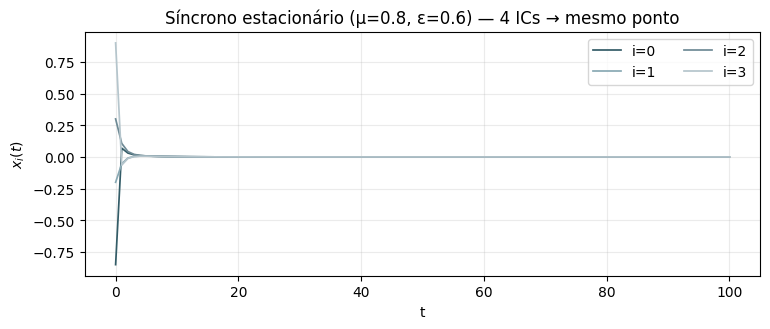

[A] λ_teo=-0.223144  λ_est=-0.223144  λ_perp=-1.139434


In [11]:
# ----- Síncrono estacionário (μ<1) -----
MU_STAT = 0.8
EPS_STAT = 0.6
N = 64
# x0: quatro pontos bem distintos, resto aleatório (não influencia a convergência)
rng = np.random.default_rng(42)
x0 = rng.uniform(-1, 1, size=N)
x0[:4] = np.array([-0.85, -0.2, 0.3, 0.9])  # os quatro que vamos plotar

cfg_stat = Config(N=N, eps=EPS_STAT, mu=MU_STAT, seed=123)

# Trajetória incluindo t=0 = x0
trajA, sysA = run_track_including_initial(cfg_stat, x0=x0, T=100)
lines = []

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7.8, 3.4))
cols = ["#335c67", "#89a9b4", "#6e8a95", "#b5c5cc"]  # variações coerentes com COL_SYNC_STAT
for k, c in zip(range(4), cols):
    ln, = ax.plot(trajA[:, k], lw=1.25, color=c, label=f"i={k}")
    lines.append(ln)

# λ teórico/estimado/⊥ (usa uma das séries para λ_est)
lam_teo, lam_est, lam_perp = lambdas(MU_STAT, EPS_STAT, trajA[:, 0])
info_label = rf"λ={lam_teo:.3f} (teo) / {lam_est:.3f} (est) —  λ⊥={lam_perp:.3f}"
# “linha invisível” só para levar texto à legenda
from matplotlib.lines import Line2D
lines.append(Line2D([], [], color='none', label=info_label))

ax.set_title(rf"Síncrono estacionário (μ={MU_STAT}, ε={EPS_STAT}) — 4 ICs → mesmo ponto")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
#ax.set_yscale("log")
ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"A_sync_estacionario_quatro_ICs.png", dpi=180); plt.show()

print(f"[A] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}")



**Leitura rápida do gráfico:** 

Como já vimos, no notebook passado, para $|\mu|<1$ uma faixa de $\varepsilon$ considerável próxima de 1 nos faz estar dentro da zona de sincronia **estacionária**, i.e., todos convergem para o mesmo valor de $x$, que chamemos de $x*$. Além disso, podevemos nos resultados que ambos, $\lambda_{est}$ e $\lambda_{\perp}$ são negativos. O modo perpendicular ser negativo, indica que estamos na sincronia, como esperado, enquanto $\lambda_{est}$ ser negativo, nos indica que se trata de uma sincronia **estacionária**.


O que podemos entender: Se $|\mu|<1$ o mapa local tende a contrair, i.e, suprimir o seu valor ao longo do tempo, como se o átomo não enxerguasse mais os seus vizinhos para alterar seu estado de energia. Além disso, para haver algum disturbio provocado a força de acoplameto global deve ser muito grande, para compensar o fato de que $\mu$ é pequeno. É claro que quando menor $\mu$ maior deve ser $\varepsilon$ para compensar.
 
No gráfico acima, o que observamos, é o comportamento de 4 trajetórias específicas $x_i^{t}$ com condições iniciais bem diferentes. O que observamos é que todas elas, para esse valor de $\varepsilon$ e $\mu$ convergem para o mesmo valor de $x$ que é $x*=0$.

## Parte B -- Síncrono caótico ($\mu=1.9$)

> Mostramos duas execuções com $\varepsilon$ na banda **sincronizada** de forma que observemos os dois atratores $I_+$ e $I_-$ (todos sincronizando em um atrator caótico). 

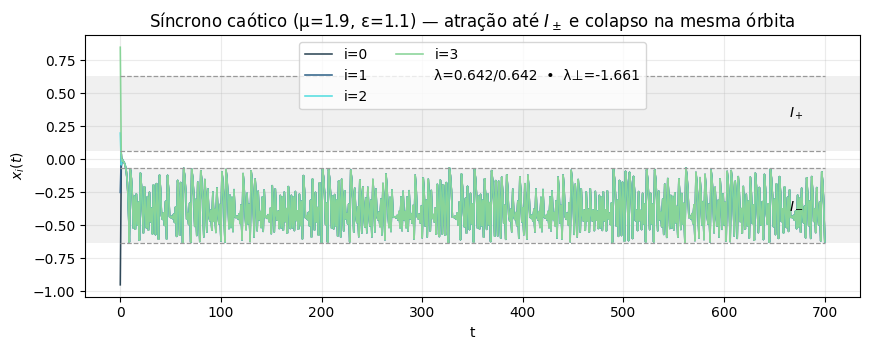

[B] λ_teo=0.641854  λ_est=0.641854  λ_perp=-1.660731; com I_-=(-0.6333333333333333, -0.0633333333333334); I_+ = (0.0633333333333334, 0.6333333333333333)


In [6]:
# ----- Síncrono caótico (μ>1) -----
MU = 1.9
EPS_SC = 1.1         # dentro da banda (sincroniza)
N = 512
T = 700

i_minus, i_plus = bistable_intervals(MU)

def make_ic_far_from_attractors(N, seed=7):
    rng = np.random.default_rng(seed)
    x0 = rng.uniform(-1.0, 1.0, size=N)
    # garanta alguns pontos “distantes” dos intervalos, para visual
    x0[0] = -0.95   # bem negativo
    x0[1] = -0.25   # miolo negativo
    x0[2] =  0.20   # miolo positivo
    x0[3] =  0.85   # bem positivo
    return x0

cfg_sc = Config(N=N, eps=EPS_SC, mu=MU, seed=1001)
x0_sc = make_ic_far_from_attractors(N, seed=103)
trajB, sysB = run_track_including_initial(cfg_sc, x0=x0_sc, T=T)

fig, ax = plt.subplots(figsize=(8.8, 3.6))
colsB = ["#2f4858", "#33658a", "#55dde0", "#88d498"]
for k, c in zip([0,1,2,3], colsB):
    ax.plot(trajB[:, k], lw=1.15, color=c, label=f"i={k}")

# Evidencia I_- e I_+ com linhas horizontais e sombreamento
ax.hlines([i_minus[0], i_minus[1]], xmin=0, xmax=T, colors="#999999", linestyles="--", lw=0.9)
ax.hlines([i_plus[0],  i_plus[1]],  xmin=0, xmax=T, colors="#999999", linestyles="--", lw=0.9)
ax.axhspan(i_minus[0], i_minus[1], color="k", alpha=0.06, linewidth=0)
ax.axhspan(i_plus[0],  i_plus[1],  color="k", alpha=0.06, linewidth=0)
ax.text(T*0.97, np.mean(i_plus),  r"$I_+$", ha="right", va="center")
ax.text(T*0.97, np.mean(i_minus), r"$I_-$", ha="right", va="center")

# λs
lam_teo, lam_est, lam_perp = lambdas(MU, EPS_SC, trajB[:, 0])
info = Line2D([], [], color='none', label=rf"λ={lam_teo:.3f}/{lam_est:.3f}  •  λ⊥={lam_perp:.3f}")

ax.set_title(rf"Síncrono caótico (μ={MU}, ε={EPS_SC}) — atração até $I_\pm$ e colapso na mesma órbita")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
ax.legend(handles=[*ax.get_lines(), info], loc="best", ncol=2, frameon=True)

fig.tight_layout(); fig.savefig(FIGS/"B_sync_caotico_sem_burn_Ipm.png", dpi=180); plt.show()
print(f"[B] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}; com I_-={i_minus}; I_+ = {i_plus}")


**Intepretação do gráfico: Por que dois atratores?** 

Observamos que, diferentemente do caso anterior, temos $\lambda_{est}>0$ enquanto mantemos $\lambda_{\perp}<0$. O que isso significa?

Significa que os modos transversais estão sendo suprimidos ainda, devido ao valor próximo de 1 de $\epsilon$. Entretanto, como o mapa local possui grande força, diferente do caso anterior, ou seja, $|\mu|>1$, temos um regime caótico, no qual o sistema tende a um dos dois atratores $I_+$ ou e $I_-$ dados por:


$$I_{\pm}=[\pm \mu(2-\mu)/3, \pm \mu/3]$$

O sistema fica em uma órbita caótica e, com o passar do tempo, tende a um dos dois atratores [MUdando as condições iniciais somos jogados ou para $I_+$ ou para $I_-$]. O acomplamento global faz com que todos os sistemas sigam a mesma órbita para tempos grandes, enquanto a força grande do mapa local não permite que o sistema entre em um estado totalmente estacionário em um valor único de x.

Entretanto, note: Todos os $x_i$ tendem a seguir a mesma órbita com o passar do tempo, mesmo que o sistema seja caótico podemos prever o que todos os mapas vão fazer no próximo passo. Isso nos diz algo importante que já vimos: O caos não é sinônimo de aleatoriedade e pode ser previsível.

Em resumo:
Para $ |\mu |>1$ e dentro da banda síncrona, entramos na síncronia caótica. O mapa local é **biestável**. 

O que isso significa? Existem dois atratores $I_{\pm}=[\pm \mu(2-\mu)/3, \pm \mu/3]$ que levam $x^{t}$ nessa direção ao longo do tempo. 

Diferente do caso anterior, o mapa local é forte o suficiente para que os átomos sempre vejam seus vizinhos e isso gera instabilidade. Ao mesmo tempo, por existir uma força global $\epsilon$, todos convergem para o mesmo regime caótico e um dos atratores vence.

Ou seja, a tendência global alinha todos para seguir a mesma órbita, enquanto o mapa local faz com que o caminho seguido por todos fique tortuoso e caótico. Assim como antes, por $\mu$ ser maior, $\varepsilon$ deve estar mais próximo de 1 para garantir a sincronia (maior acoplamento global).

Em nossa analogia, o que temos é: O acoplamento global é forte o bastante para sincronizar todas as trajetórias, que olam na mesma órbita -- mas essa órbita pode residir em $I_{+}$ ou em $I_{-}$ dependendo do viés inicial - Imagine que um tipo de canais já era mais popular logo de ínicio (campo médio "escolhe o lado" que todos devem seguir). O peso da manchete nacional garante que o canal inicialmente mais popular vença e que todos sigam o mesmo regime de canais.

Abaixo segue mais um exemplo ilustrativo.

## Parte C -- Estados não sincronizados e caso de escape

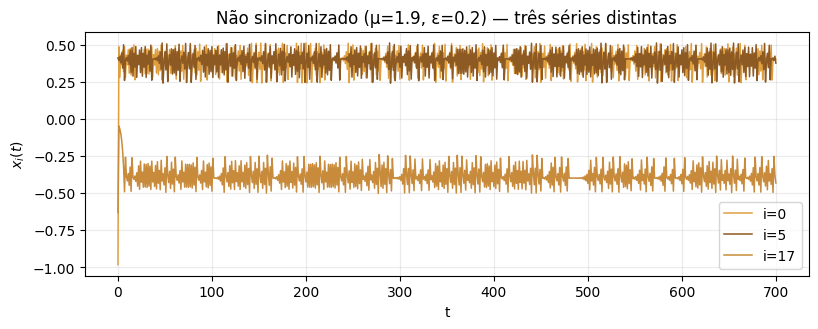

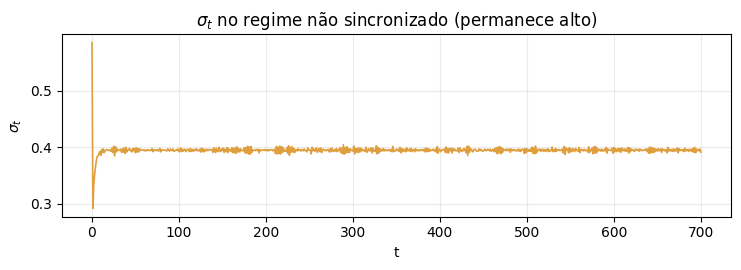

[C] λ_teo=0.641854  λ_est=0.641854  λ_perp=0.418710  (λ⊥ esperado > 0 aqui)


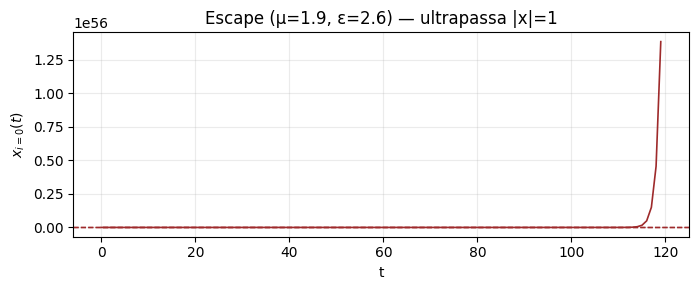

In [7]:
# ----- Não sincronizado (fora da banda) -----
MU = 1.9
EPS_NS = 0.2      # << 0.473 (limiar inferior), logo não sincroniza
N = 512
T = 700

cfg_ns = Config(N=N, eps=EPS_NS, mu=MU, seed=2027)

# IC uniformes em [-1,1] para evitar viés escondido
rng = np.random.default_rng(2027)
x0_ns = rng.uniform(-1.0, 1.0, size=N)

trajE, sysE = run_track_including_initial(cfg_ns, x0=x0_ns, T=T)

# 3 séries e σ_t
sigmas = np.std(trajE, axis=1)

fig, ax = plt.subplots(figsize=(8.2, 3.4))
for idx, c in zip([0, 5, 17], [COL_NON_SYNC, "#8e5a23", "#c88b3b"]):
    ax.plot(trajE[:, idx], lw=1.1, color=c, label=f"i={idx}")
ax.set_title(rf"Não sincronizado (μ={MU}, ε={EPS_NS}) — três séries distintas")
ax.set_xlabel("t"); ax.set_ylabel(r"$x_i(t)$"); ax.grid(alpha=0.25)
ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"E_ns_tres_series_ok.png", dpi=170); plt.show()

# σ_t (se estivesse sincronizando, cairia ~0)
fig, ax = plt.subplots(figsize=(7.6, 2.8))
ax.plot(sigmas, lw=1.2, color=COL_NON_SYNC)
ax.set_title(r"$\sigma_t$ no regime não sincronizado (permanece alto)")
ax.set_xlabel("t"); ax.set_ylabel(r"$\sigma_t$"); ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"E_ns_sigma_t.png", dpi=170); plt.show()

lam_teo, lam_est, lam_perp = lambdas(MU, EPS_NS, trajE[:, 0])
print(f"[C] λ_teo={lam_teo:.6f}  λ_est={lam_est:.6f}  λ_perp={lam_perp:.6f}  (λ⊥ esperado > 0 aqui)")


# Escape: para μ=1.9, uma condição de escape acontece para ε ≳ 2.579
MU = MU_MAIN
EPS_ESC = 2.60
N = 128
traj_e, sys_e = run_with_ic(mu=MU, eps=EPS_ESC, N=N, init="uniform",
                            T_burn=1, T_meas=120, seed=505)

# Mostra um índice que sai de |x|>1
xi = traj_e[:,0]
fig, ax = plt.subplots(figsize=(7.0,3.0))
ax.plot(xi, lw=1.2, color=COL_ESCAPE)
ax.axhline( 1.0, color=COL_ESCAPE, ls="--", lw=1.0)
ax.axhline(-1.0, color=COL_ESCAPE, ls="--", lw=1.0)
ax.set_xlabel("t"); ax.set_ylabel(r"$x_{i=0}(t)$")
ax.set_title(rf"Escape (μ={MU}, ε={EPS_ESC}) — ultrapassa |x|=1")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"E_escape_um_indice.png", dpi=170); plt.show()

Por fim, observamos as outras dois reigões do gráfico que não cobrimos: A região de não sincronia e a região de escape.

**Região de escape:** Nela não ná nada demais, apenas mostro que de fato para um valor muio grande $\varepsilon$ acabamos fazendo com que $x_i$ saia da região de [+1,-1] o que prejudica toda a análise dos resultados.

Agora sobre a região de fato mais importante:

**Região de não sincronia:** Observamos que, diferentemente de antes ambos $\lambda$ são positivos. Como já discutimos o que esperamos é que os modos tranversos não sejam suprimidos ao longo do tempo, fazendo com que os diferentes mapas nunca atinjam a sincronia, ou seja, mesmo para um tempo muito longo os mapas continuam seguindo caminhos diferentes. Isso acontece pelo seguinte motivo: se $|\varepsilon|\gg 1 $ a força de acoplamento fica menor, fazendo com que o mapa local domine e nenhuma tendência fosse seguida. Em nossa analogia é o seguinte: A manchete nacional não possui tanta influência sobre as casas, de modo que elas própria escolhem seus canais ou por meio de seus vizinhos e assim vários sítios são formados sem nenhuma sincronia.

**Como medir os observáveis:** Fica claro que há uma diferença muito grande entre a região síncrona e não síncrona e que há também uma transição entre essas regiões. 

O que o artigo propõe e quer focar é justamente sobre a transição entre a região síncrona e não síncrona. Para isso devemos definir uma classe de observáveis que serão uteis para nós ao longo do caminho. Isso será feito na seção abaixo, porém no gráfico acima, já podemos ver que o desvio padrão entre os mapas é importante, de modo que ele vai ser um dos observáveis para verificarmo a sincronia ou não do sistema.

## Parte D -- Definindo sincronização e variáveis $\sigma$, $s$ e M

O artigo foca, sobretudo, em observar a transição de fase entre a parte síncrona caótica e não síncrona, observando o efeito dessa transição.

Para isso, precisamos estabelecer uma variável estatística que consiga distinguir os dois estados sem ser $\mu$ e $\lambda$, que são apenas teóricos.

* **Variável** $\sigma_t$:
Uma variável fácil de ser calculada e excelente para medir a sincronia ou não dos estados é o desvio padrão instantâneo entre os mapas.

O que ele quer dizer? Pode deixar evoluir os N mapas por um tempo t e, após esse tempo, calcular o desvio padrão do conjunto $x_i^{t}$ o que nos fornece $\sigma_t$, o desvio padrão instantâneo. É claro que se os estados tados estão sincronizados todos os $x_i^{t}$ estão próximos um do outro ou, no melhor dos casos, são exatamente os mesmos, de modo que $\sigma_t$ deve tender a 0 para um tempo grande o suficiente, nos estados síncronos. Já para os não síncronos esperamos que $\sigma_t$ se estabilize em um valor maior que 0. 

$\sigma_t$ portanto será nossa variável e o critério utilizado para definir se para um dado valor de $\mu$ e $\varepsilon$ o conjunto de mapas convergiu ou não.

Outras variáveis importantes seriam as que estão ligadas a uma possível transição de fase: Ou seja, uma variável associada ao ordenamento do sistema.

Como no regime caótico há dois possível atratores, $I_+$ e $I_-$ podemos definir um parâmetro de ordem da seguinte forma:

* **Variável** $s_i^{t}$ (spin). Podemos definir uma variável de spin associada ao sinal de $x_i$; se $x_i$ é positivo essa variável é +1; se for negativo é -1, simples assim. Ou seja, teremos $s_i^{t} = sign(x_i^{t}) \in {+1,-1}$

A partir dessa construção conseguimos definir 2 outras variáveis importantes para distinguir nosso sistema:

* $M_t$: Magnetização média do sistema no tempo t, definida simplesmente pela média dos spins no tempo t. $\langle M \rangle$ pode ser entendido como o parâmetro de ordem do ssitema.

$$M_t = \frac{1}{N} \sum_i s_t^{t} $$

* Persistência $p_t:$ fração de partículas (mapas) cujo spin **nunca** mudou até o tempo t.

Já está claro nesse ponto que existe uma transição de fase entre esses regimes. O que vamos trabalhar é fixarmos $\mu$ e variarmos $\epsilon$ para observamos o comportamento de nossos observáveis nessa transição.

[D] Resumo λ e λ⊥ por ε (μ=1.9)
  ε=0.250 | estado=não sincronizado | λ=0.641854/0.641854 | λ⊥=0.354172
  ε=0.450 | estado=não sincronizado | λ=0.641854/0.641854 | λ⊥=0.044017
  ε=0.800 | estado=  sincronizado | λ=0.641854/0.641854 | λ⊥=-0.967584
  ε=1.200 | estado=  sincronizado | λ=0.641854/0.641854 | λ⊥=-0.967584


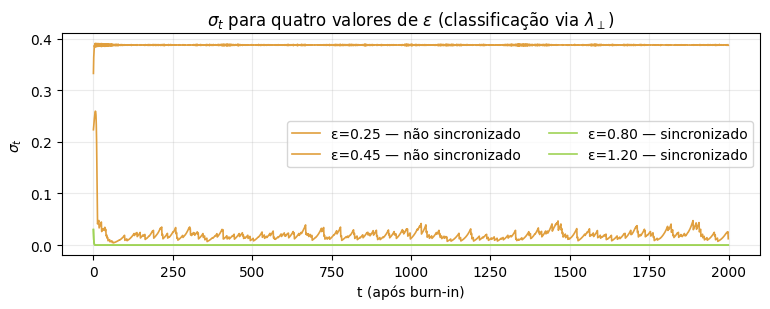

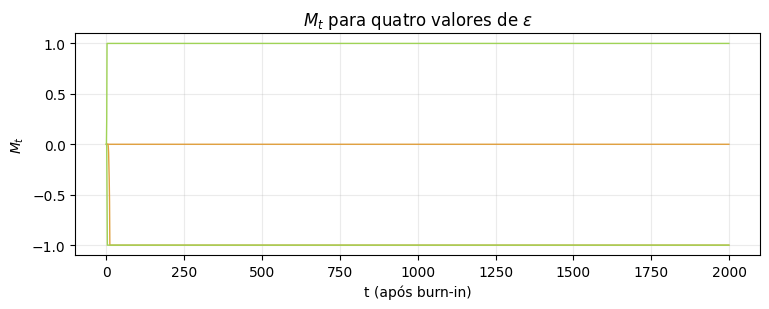

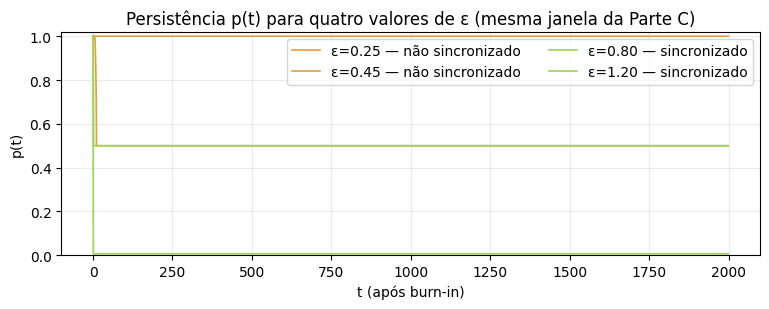

In [8]:
# ===== Parte D  =====
MU = MU_MAIN  # 1.9
# 4 eps que cobrem: não sinc. (<<0.473), perto da borda (<0.473), sinc. caótico (dentro da banda)
EPS_LIST_C = [0.25, 0.45, 0.80, 1.20]   # você pode ajustar depois; a classificação abaixo é automática
N = 10000
T_BURN, T_MEAS = 1, 2000

def classify_by_lambda_perp(mu, eps):
    lam_teo = math.log(abs(mu))
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo
    return ("sincronizado" if lam_perp < 0 else "não sincronizado"), lam_teo, lam_perp

def compute_TS(mu, eps, N, T_burn, T_meas, seed=2025):
    traj, sys = run_with_ic(mu=mu, eps=eps, N=N, init="half_half",
                            T_burn=T_burn, T_meas=T_meas, seed=seed)
    sigmas = np.std(traj, axis=1)
    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    return traj, sigmas, Ms

# roda e coleta
resC = []
for eps in EPS_LIST_C:
    traj, sigmas, Ms = compute_TS(MU, eps, N, T_BURN, T_MEAS, seed=2025+int(1000*eps))
    state, lam_teo, lam_perp = classify_by_lambda_perp(MU, eps)
    # λ_est: basta estimar uma única vez (vale para todos ε)
    lam_est = estimate_lambda_local(traj[:, 0], MU)
    resC.append({
        "eps": eps, "traj": traj, "sigmas": sigmas, "Ms": Ms,
        "state": state, "lam_teo": lam_teo, "lam_est": lam_est, "lam_perp": lam_perp
    })

# imprime resumo de λ e λ⊥
print("[D] Resumo λ e λ⊥ por ε (μ=1.9)")
for r in resC:
    print(f"  ε={r['eps']:.3f} | estado={r['state']:>14s} | λ={r['lam_teo']:.6f}/{r['lam_est']:.6f} | λ⊥={r['lam_perp']:.6f}")

# plot σ_t para os 4 ε
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(r["sigmas"], lw=1.2, color=color, label=f"ε={r['eps']:.2f} — {r['state']}")
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel(r"$\sigma_t$")
ax.set_title(r"$\sigma_t$ para quatro valores de $\varepsilon$ (classificação via $\lambda_\perp$)")
ax.grid(alpha=0.25); ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_sigma_t_quatro_eps.png", dpi=180); plt.show()

# plot M_t para os 4 ε
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(r["Ms"], lw=1.0, color=color, label=f"ε={r['eps']:.2f} — {r['state']}")
ax.set_xlabel("t (após burn-in)"); ax.set_ylabel(r"$M_t$")
ax.set_title(r"$M_t$ para quatro valores de $\varepsilon$")
ax.grid(alpha=0.25); #ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_M_t_quatro_eps.png", dpi=180); plt.show()


# === PLotando p(t)===

# p(t) para os mesmos 4 epsilons
fig, ax = plt.subplots(figsize=(7.8, 3.2))
for r in resC:
    # r["traj"] tem shape (T_meas, N)
    S = spins(r["traj"])                  # (T_meas, N) em {-1,+1}
    p = persistence_curve(S)              # (T_meas,)
    color = COL_SYNC_CHAOS if r["state"]=="sincronizado" else COL_NON_SYNC
    ax.plot(p, lw=1.2, color=color,
            label=f"ε={r['eps']:.2f} — {r['state']}")

ax.set_xlabel("t (após burn-in)")
ax.set_ylabel("p(t)")
ax.set_ylim(0.0, 1.02)
ax.set_title("Persistência p(t) para quatro valores de ε (mesma janela da Parte C)")
ax.grid(alpha=0.25)
ax.legend(loc="best", ncol=2, frameon=True)
fig.tight_layout(); fig.savefig(FIGS/"C_p_t_quatro_eps.png", dpi=180); plt.show()


**Discussão sobre o gráfico:**

* $\sigma_t$: O que observamos no gráfico é uma intuição sobre a transição de fase: Para diferentes valores de $\varepsilon$ e  $\sigma_t$ se estabiliza em certo lugar. Note que os estados sincronizados ambos vão para $\sigma_t \approx 0$ quando o tempo é grande o suficiente e isso está de acordo com as expectativas associada ao valor de seu $\lambda_{\perp}$. Para não sincronia ainda vemos dois casos bem distintos: Primeiro um estado não sincronizado que possui $\sigma_t$ alto ao longo de todo tempo. Outro, para um $\varepsilon$ maior, a força do acoplamento global já é suficientemente grande para diminuir $\sigma_t$ consideravelmente, entretanto, ainda temos flutuações que não o fazem chegar a 0, como visto acima.

[Podemos testar para diferentes valores de $\varepsilon$ caso desejem].

* $M_t$: Nesse gráfico, com os mesmo valores, já conseguimos ver comportamentos bem distintos. Para o estado não sincronizado com $\varepsilon$ grande, $M_t$ tende a convergir para $|M|=1$, ainda que as órbitas não estejam totalmente sincronizadas. O que isso significa? Os $x_t^{i}$ tendem a adiquir um sinal global, entretanto ainda estão dessincronizados, com cada $x_i^{t}$ seguindo sua própria órbita.

No caso do estado não sincronizado com $\varepsilon$ baixo temos o resultado esperado: O parâmetro de ordem indica se encontra em 0, ou seja, o sistema se encontra desordenado.

No caso dos estados sincronizados novamente temos os resultados esperados $|M|=1$ ou seja, temos uma configuração ordenada do sistema.


* $p(t):$ O que esse gráfico nos diz é que no caso não sincronizado todos tendem a manter os mesmos spins ao longo de todo o tempo, ou seja, algúem que começou num valor negativo (positivo) de $x_i$ tende a permaneceer nesse lado ao longo da evolução temporal. Já nos outros casos, aproxidametne metade dos spins tendem a trocar de lado conforme o tempo passo indo para onde a manchete nacional (força global) atrai todos. Para $\varepsilon$ vemos um resultado ainda mais estranho, parece que todos os spins trocam de sinal ao menos uma vez rapidamente. Isso nos leva a uma série de questionamentos sobre o comportamento dos observáveis com $\varepsilon$

Esses 3 simples gráficos nos leva ao seguinte pensamento: O sistema pode estar ordenado e ao mesmo tempo não sincronizado para um certo regime de $\varepsilon$, ou ordenado e sincronizado ou até casos que possivelmente não exploramos aqui para os valores de $\varepsilon$ testados. 

Dessa forma, se mostra necessário estudarmos a fundo a variação desses parâmetros não ao longo do tempo, mas ao longo de $\varepsilon$, para um tempo muito grande (quando o sistema já estiver se estabilizado, entrado em **"equilíbrio"**).



## Parte E -- Distribuições de x para diversos $\varepsilon$

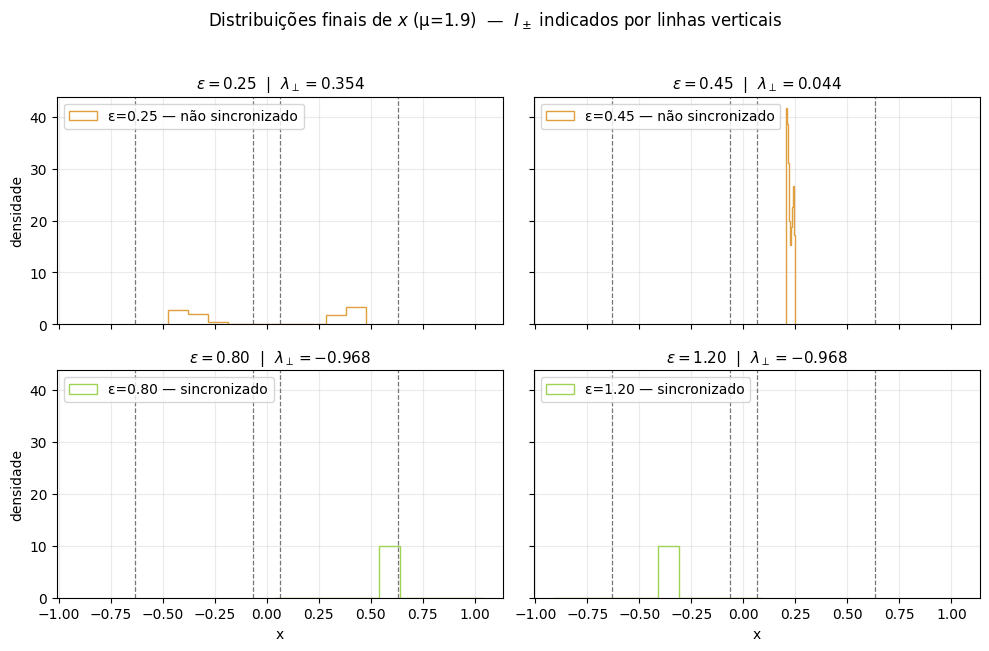

[D] λ (teo/est): 0.641854 / 0.641854
    ε=0.250 -> estado=não sincronizado | λ⊥=0.354172
    ε=0.450 -> estado=não sincronizado | λ⊥=0.044017
    ε=0.800 -> estado=  sincronizado | λ⊥=-0.967584
    ε=1.200 -> estado=  sincronizado | λ⊥=-0.967584


In [9]:
# ===== Parte E (substituir) =====
MU = MU_MAIN  # 1.9
EPS_LIST_D = EPS_LIST_C  # reaproveita os 4 ε da parte C
N = 1024
T_BURN, T_MEAS = 1200, 1200

# roda para cada ε e guarda o estado final
finals = {}
states = {}
lam_perps = {}
lam_teo = math.log(abs(MU))  # único para todos
# também registremos λ_est uma vez
lam_est_once = None

for eps in EPS_LIST_D:
    traj, sys = run_with_ic(mu=MU, eps=eps, N=N, init="half_half",
                            T_burn=T_BURN, T_meas=T_MEAS, seed=2025+int(1000*eps))
    finals[eps] = sys.x.copy()
    state, _, lam_perp = classify_by_lambda_perp(MU, eps)
    states[eps] = state
    lam_perps[eps] = lam_perp
    if lam_est_once is None:
        lam_est_once = estimate_lambda_local(traj[:,0], MU)

# intervalos I_± (fixos para MU)
i_minus, i_plus = bistable_intervals(MU)
xlines = [i_minus[0], i_minus[1], i_plus[0], i_plus[1]]

# 2x2 hist
fig, axes = plt.subplots(2, 2, figsize=(10, 6.6), sharex=True, sharey=True)
axes = axes.ravel()

for ax, eps in zip(axes, EPS_LIST_D):
    color = COL_SYNC_CHAOS if states[eps]=="sincronizado" else COL_NON_SYNC
    ax.hist(finals[eps], histtype="step", density=True, color=color, label=f"ε={eps:.2f} — {states[eps]}")
    # linhas VERTICAIS indicando I_- e I_+
    for xv in xlines:
        ax.axvline(xv, color="#777777", lw=0.9, ls="--")
    ax.set_title(rf"$\varepsilon={eps:.2f}$  |  $\lambda_\perp={lam_perps[eps]:.3f}$", fontsize=11)
    ax.grid(alpha=0.25); ax.legend(loc="upper left", frameon=True)

axes[2].set_xlabel("x"); axes[3].set_xlabel("x")
axes[0].set_ylabel("densidade"); axes[2].set_ylabel("densidade")
fig.suptitle(rf"Distribuições finais de $x$ (μ={MU})  —  $I_\pm$ indicados por linhas verticais", y=0.98)
fig.tight_layout(rect=[0,0,1,0.96]); fig.savefig(FIGS/"D_hist_x_quatro_eps_com_Ipm.png", dpi=190); plt.show()

print(f"[D] λ (teo/est): {lam_teo:.6f} / {lam_est_once:.6f}")
for eps in EPS_LIST_D:
    print(f"    ε={eps:.3f} -> estado={states[eps]:>14s} | λ⊥={lam_perps[eps]:.6f}")


**Discussão:**

Acima vemos os gráficos de densidade para cada um dos casos anteirores. Com eles entendemos melhor o que acontece na figura final. Mesmo após um tempo longo, os estados sincronizados não ficam todos juntos mesmo após um longo periodo de tempo, entretanto para $\varepsilon = 0.45$ já vemos uma concentração dos dados em torno de algum valor, mesmo com as órbitas não sincronizadas. Nos casos de sincronia, temos exatamente o que esperávamos, todos concentrado em um dado valor. No caso de não sincronia maior, há uma dispersão maior dos valores de $x_i$.

# Varredura em $\epsilon:\bar{\sigma}(\epsilon), |\langle M\rangle|(\epsilon), p(t)$ e checagem com fronteiras teóricas

1) $\bar{\sigma}(\epsilon)+$ pontos do mapa teórico
2) Curva de persistência p(t) para $\epsilon$ representativos
3) Parâmetro de ordem $|\langle M\rangle|(\epsilon)$  + comparação qualitativa com o paper

## Imports & Setup

In [10]:
import os, sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np, math, json
import matplotlib.pyplot as plt
from pathlib import Path

from gcm.core import Config, GloballyCoupledMaps
from gcm.maps import sync_boundaries, escape_boundaries, bistable_intervals
from gcm.metrics import spins, persistence_curve, magnetization, order_param_M

FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

def estimate_lambda_local(x_series, mu):
    """λ_est ≈ mean_t ln|f'(x_t)| (tempo finito). Para este mapa, ~ ln|μ|."""
    fp = fprime_piecewise(x_series, mu)
    return float(np.mean(np.log(np.abs(fp))))



def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp


def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    traj = sys.run(T_meas, track=True)
    return traj, sys


# Paleta de regiões (mesma dos notebooks anteriores)
COL_NON_SYNC  = "#e09f3e"  # não sincronizado (Honey Bronze)
COL_SYNC_STAT = "#335c67"  # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS= "#9fd356"  # síncrono caótico (Yellow Green)
COL_ESCAPE    = "#9e2a2b"  # escape (Brown Red)

# Paleta dos 3 traços solicitados (M, sigma, p∞):
COL_CURVE_M     = "#7e57c2"  # roxo (M)
COL_CURVE_SIGMA = "#e09f3e"  # laranja (σ)
COL_CURVE_P     = "#2e7d32"  # verde (p∞)

MU = 1.9           # foco do artigo
N  = 50000
T_BURN = 5000
T_MEAS = 5000
TOL_SYNC = 1e-7


## Parte A -- Varredura em $\varepsilon \in [0,2]$ dos observáveis em $\mu=1.9$

In [11]:
# Malha de ε
EPS_GRID = np.linspace(0.0, 2.0, 60) # passo

p_infty = []
sigma_bar = []
M_bar = []
escaped_frac = []

for i, eps in enumerate(EPS_GRID):
    # roda sistema (IC half_half como padrão do projeto)
    traj, sys = run_with_ic(mu=MU, eps=eps, N=N, init="half_half",
                            T_burn=T_BURN, T_meas=T_MEAS, seed=1000+i)

    # σ̄: média temporal do desvio-padrão entre os N mapas
    sigmas = np.std(traj, axis=1)
    sigma_bar.append(float(np.mean(sigmas)))

    # |<M>|: média temporal do módulo de M_t
    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    M_bar.append(float(order_param_M(Ms)))

    # p_infty: último valor da curva de persistência
    S = spins(traj)           # (T_meas, N) em {-1, +1}
    p_t = persistence_curve(S)
    p_infty.append(float(p_t[-1]))

    # escaped (fração fora de [-1,1] ao final)
    escaped_frac.append(float(np.mean(np.abs(sys.x) > 1.0)))

p_infty  = np.array(p_infty)
sigma_bar= np.array(sigma_bar)
M_bar    = np.array(M_bar)
escaped_frac = np.array(escaped_frac)

# Guarda CSV/JSON
np.savetxt(DATA/"eps_scan_mu1.9.csv",
           np.c_[EPS_GRID, p_infty, sigma_bar, M_bar, escaped_frac],
           delimiter=",", header="eps,p_infty,sigma_bar,M_bar,escaped_frac", comments="", fmt="%.8g")
(DATA/"eps_scan_mu1.9.json").write_text(
    json.dumps({"eps": EPS_GRID.tolist(),
                "p_infty": p_infty.tolist(),
                "sigma_bar": sigma_bar.tolist(),
                "M_bar": M_bar.tolist(),
                "escaped_frac": escaped_frac.tolist()}, indent=2),
    encoding="utf-8")


5347

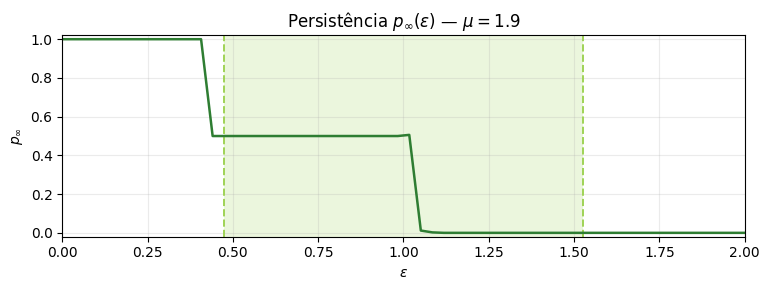

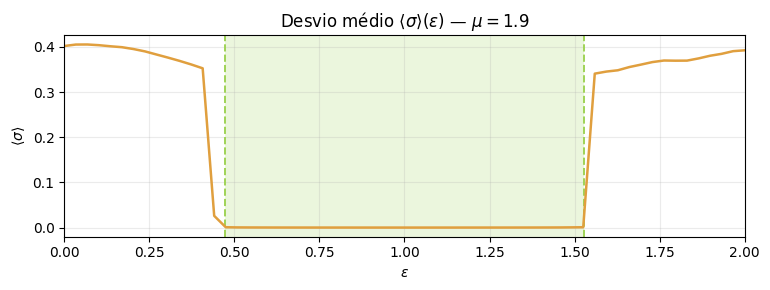

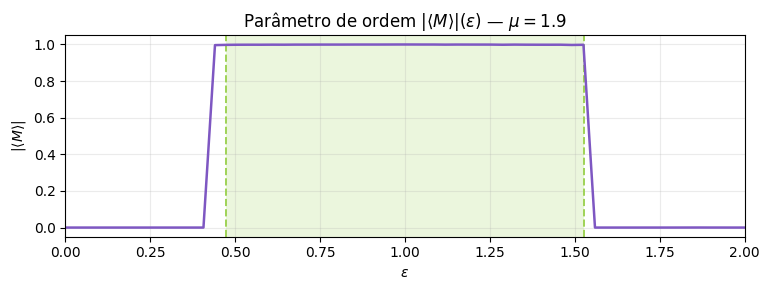

In [12]:
# Fronteiras teóricas para MU=1.9
eps_sync_inf, eps_sync_sup = sync_boundaries(MU)  # ~ 0.473, 1.526
esc_lo, esc_hi             = escape_boundaries(MU) # ~ -0.579, 2.579 (não pega escape no eixo até 2)

def shade_sync_band(ax, mu, color, alpha=0.12):
    a, b = sync_boundaries(mu)
    ax.axvspan(max(0,a), min(2,b), color=color, alpha=alpha, linewidth=0)

# p∞(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, p_infty, lw=1.8, color=COL_CURVE_P)
ax.set_xlim(0, 2); ax.set_ylim(-0.02, 1.02)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$p_\infty$")
ax.set_title(rf"Persistência $p_\infty(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_pinf_vs_eps_mu1.9.png", dpi=200); plt.show()

# σ̄(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, sigma_bar, lw=1.8, color=COL_CURVE_SIGMA)
ax.set_xlim(0, 2)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$\langle \sigma \rangle$")
ax.set_title(rf"Desvio médio $\langle \sigma \rangle(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_sigma_bar_vs_eps_mu1.9.png", dpi=200); plt.show()

# |<M>|(ε)
fig, ax = plt.subplots(figsize=(7.8, 3.0))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, 0.20)
ax.axvline(eps_sync_inf, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.axvline(eps_sync_sup, color=COL_SYNC_CHAOS, lw=1.4, ls="--")
ax.plot(EPS_GRID, M_bar, lw=1.8, color=COL_CURVE_M)
ax.set_xlim(0, 2)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M \rangle|$")
ax.set_title(rf"Parâmetro de ordem $|\langle M \rangle|(\varepsilon)$ — $\mu={MU}$")
ax.grid(alpha=0.25)
fig.tight_layout(); fig.savefig(FIGS/"02_Mbar_vs_eps_mu1.9.png", dpi=200); plt.show()

**Discussão sobre o gráfico**

Lembrando que essa varredura em $\varepsilon$ está fixada em $\mu=1.9$. 

O que observamos olhando o gráfico é que há 3 situações diferentes conforme variamos $\varepsilon$ com $|M|= 1$ (estado ordenado). 

* (i): Um estado **ordenado** e **dessincronizado** com $\sigma >0$  e $p_\infty = 0.5$.
* (ii): Um estado **ordenado** e **sincronizado** com $\sigma =0$ e $p_\infty = 0.5$.
* (iii): Um estado **ordenado** e **sincronizado** com $\sigma =0$ e $p_\infty = 0.0$.

O que isso significa? No primeiro caso é o que já vimso e entendemos, o sistema ainda não atingiu a sincronia, mas a maioria dos mapas já se concentra em dos lados (positivo ou negativo) de $x$. Isso está refletido em $p_\infty$, note que metade dos mapas trocaram seu valor ao longo do tempo nessa região.

Já para (ii), temos o caso mais intuitivo de todos, o sistema se encontra ordenado e sincronizado, para isso aproximadamente metade dos spins precisou trocar de lado.

Por fim, o caso mais estranho parece ser o (iii). O sistema se encontra ordenado e sincronizado, entretanto todos os spins trocaram de sinal ao menos uma vez ao longo do tempo, indicando por $p_infty=0$. Isso acontece pois $(1-\varepsilon)$ torna-se negativo e todos são jogados para o lado contrário de seus sinais iniciais. Estamos novamente em uma região turbulenta, mas podemos interpretar que a força global faz todos mudarem de lado sem se estabilizar. No caso de $\varepsilon$ pequeno o que encontramos é uma situação contrária a força global não é suficiente para nada, ou seja, todos ficam próximo de seus sinais iniciais, sem sincronizar. Isso quer dizer que se a manchete nacional for extremamente influente o impacto é na verdade negativo. Todos trocam de opinião o tempo todo e ninguém estabiliza na mesma rota/canal.

## Parte B) Pontos simulados no plato ($\mu$, $\varepsilon$) e comparação com fronteiras teóricas

Podemos simular pontos teóricos na grade de $\mu$, $\varepsilon$ e averiguar se eles de fatam estão de acordo com as expectativas teóricas seguindo os critérios:

> * **Sincrono caótico x Não síncrono:** pelo $\langle \sigma \rangle$ para t grande.
> * **Síncrono estacionário:** Além de $\sigma$ ser próximo de 0 a média de $x$ deve ser 0.
> * **Escape:** |x| ficou maior que 1.

In [13]:
# Grade moderada para ser rápida no Colab
MU_LIST = np.array([-2.5, -1.6, -0.8, -0.5, 0.5, 0.8, 1.1, 1.9, 2.5])
EPS_LIST = np.linspace(0.0, 2.0, 11)  # 0, 0.2, ..., 2.0

N_pts   = 400      # menor N para essa varredura 2D
T_BURN2 = 1000
T_MEAS2 = 1000
TOL_SIG = 1e-3      # critério de sincronização pelo σ médio
TOL_X0  = 1e-2       # critério "x→0" (média de |x| final pequena) para estacionário

pts_mu, pts_eps = [], []
pts_label = []   # "sync_stat", "sync_chaos", "nonsync", "escape"

def classify_point(mu, eps, N=N_pts, T_burn=T_BURN2, T_meas=T_MEAS2, seed=0):
    traj, sys = run_with_ic(mu=mu, eps=eps, N=N, init="uniform",
                            T_burn=T_burn, T_meas=T_meas, seed=seed)
    # escape?
    if np.any(np.abs(sys.x) > 1.0):
        return "escape"

    # σ médio
    sigmas = np.std(traj, axis=1)
    sig_mean = float(np.mean(sigmas))
    if sig_mean < TOL_SIG:
        # sincronizado — estacionário se x→0
        x_final = np.mean(np.abs(sys.x))
        if x_final < TOL_X0:
            return "sync_stat"
        else:
            return "sync_chaos"
    else:
        return "nonsync"

# constrói a nuvem de pontos
for i, mu0 in enumerate(MU_LIST):
    for j, eps0 in enumerate(EPS_LIST):
        lab = classify_point(mu0, eps0, seed=10000 + 100*i + j)
        pts_mu.append(mu0); pts_eps.append(eps0); pts_label.append(lab)

pts_mu = np.array(pts_mu); pts_eps = np.array(pts_eps); pts_label = np.array(pts_label)

# Salva para eventual reuso/plots adicionais
(DATA/"mu_eps_points_classified.json").write_text(
    json.dumps({"mu": pts_mu.tolist(), "eps": pts_eps.tolist(), "label": pts_label.tolist()}, indent=2),
    encoding="utf-8")


C:\Users\Igora\PycharmProjects\Projeto_Final_Python_na_Fisica\gcm\maps.py:87: RuntimeWarning: overflow encountered in multiply
  y[m_right] = 2.0 * mu / 3.0 - mu * x[m_right]
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:193: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\Igora\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:204: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where

3921

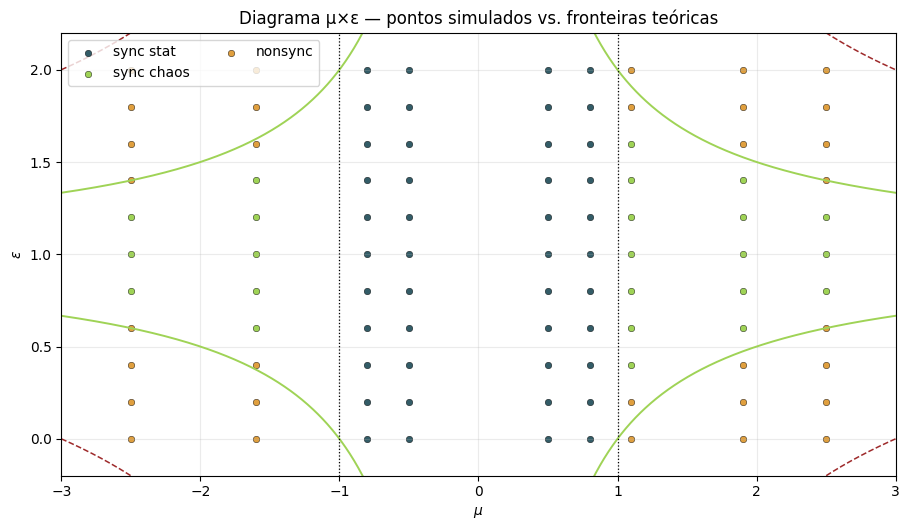

In [14]:
# Curvas teóricas no plano μ×ε
MU_GRID = np.linspace(-3.0, 3.0, 1201)
sync_lo = np.empty_like(MU_GRID); sync_hi = np.empty_like(MU_GRID)
esc_lo  = np.empty_like(MU_GRID); esc_hi  = np.empty_like(MU_GRID)
for k, mu0 in enumerate(MU_GRID):
    if abs(mu0) < 1e-12:
        sync_lo[k] = np.nan; sync_hi[k] = np.nan
        esc_lo[k]  = np.nan; esc_hi[k]  = np.nan
    else:
        a, b = sync_boundaries(mu0)
        el, eh = escape_boundaries(mu0)
        sync_lo[k], sync_hi[k] = a, b
        esc_lo[k],  esc_hi[k]  = el, eh

fig, ax = plt.subplots(figsize=(9.2, 5.4))

# Sombreamento (leve) das regiões teóricas para referência
#ax.fill_between(MU_GRID, sync_lo, sync_hi, color=COL_SYNC_CHAOS, alpha=0.18, linewidth=0)        # banda de sincronização
ax.plot(MU_GRID, sync_lo, color=COL_SYNC_CHAOS, lw=1.4)  # bordas da banda
ax.plot(MU_GRID, sync_hi, color=COL_SYNC_CHAOS, lw=1.4)

# Escape (tracejado)
ax.plot(MU_GRID, esc_lo, color=COL_ESCAPE, lw=1.1, ls="--")
ax.plot(MU_GRID, esc_hi, color=COL_ESCAPE, lw=1.1, ls="--")

# Verticais μ=±1 (apenas referencia visual)
ax.axvline(-1.0, color="k", lw=0.9, ls=":")
ax.axvline( 1.0, color="k", lw=0.9, ls=":")

# Espalhamento de pontos simulados, com cor por classe
def color_for(lbl):
    return {
        "sync_stat":  COL_SYNC_STAT,
        "sync_chaos": COL_SYNC_CHAOS,
        "nonsync":    COL_NON_SYNC,
        "escape":     COL_ESCAPE
    }[lbl]

for lbl in ["sync_stat","sync_chaos","nonsync","escape"]:
    m = (pts_label == lbl)
    if np.any(m):
        ax.scatter(pts_mu[m], pts_eps[m], s=22, c=color_for(lbl),
                   edgecolors="k", linewidths=0.3, label=lbl.replace("_", " "))

ax.set_xlim(-3, 3); ax.set_ylim(-0.2, 2.2)
ax.set_xlabel(r"$\mu$"); ax.set_ylabel(r"$\varepsilon$")
ax.set_title("Diagrama μ×ε — pontos simulados vs. fronteiras teóricas")
ax.grid(alpha=0.25); ax.legend(loc="upper left", ncol=2, frameon=True)

fig.tight_layout(); fig.savefig(FIGS/"02_mu_eps_points_vs_theory.png", dpi=220); plt.show()

A imagem acima demonstra a compatibilidade entre os pontos simulados e a teoria é claro que quanto maior o valor de N e de passos temos uma precisão maior nesse intervalo.

Esse gráfico serve apenas para observar que de fato há uma boa correspondência, mesmo para N pequeno e um número de passos não muito grande, entre a teoria e os pontos simulados, mostrando como tudo está de acordo e se encaixa.

## E adiante? 

Com isso fechamos tudo que é abordado no artigo, no grosso, mas o que exatamente isso tem a ver com **transições de fase de primeira ordem** e minha área de pesquisa (Ondas gravatcionais geradas por essas transições ).

Para entendermos isso melhor, temos que interpretar como variar $\varepsilon$ está ligado a uma transição de fase de primeira ordem e faremos isso no próximo notebook.

# Quenches, ramps e histerese (assinatura de 1ª ordem)

**Objetivo.** Mostrar, de forma quantitativa e visual, a **transição de fase de 1ª ordem coletiva** no sistema:
- Curvas **rampa-acima** (ε↑) e **rampa-abaixo** (ε↓) para $|\langle M\rangle|$, $\langle\sigma\rangle$, $p_\infty^{\rm ramp}$ com **histerese**.
- Histogramas de $x$ perto da faixa crítica, exibindo **coexistência/bimodalidade**, a marca registrada de 1ª ordem.


## Imports & Setup

In [15]:
import os, json, math, numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import sys
# garante que o pacote local seja enxergado (repo/notebooks -> adicionar o diretório pai)
sys.path.append(os.path.dirname(os.getcwd()))

from gcm.core import Config, GloballyCoupledMaps
from gcm.metrics import spins, persistence_curve, magnetization, order_param_M
from gcm.maps import sync_boundaries, escape_boundaries, bistable_intervals


def run_with_ic(mu, eps, N=512, init="half_half", T_burn=600, T_meas=600, seed=0):
    """Roda com um init padrão do core; retorna (traj, sys)."""
    cfg = Config(N=N, eps=eps, mu=mu, seed=seed)
    sys = GloballyCoupledMaps(cfg)
    sys.reset(init=init)
    sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)
    return traj, sys

def run_track_including_initial(cfg, init_kind="half_half", x0=None, T=400, seed=None):
    """
    Executa e retorna uma matriz (T+1, N) que INCLUI o estado inicial na linha 0.
    Se x0 for fornecido, usa-o diretamente; caso contrário, chama reset(init_kind).
    """
    from gcm.core import GloballyCoupledMaps
    sys = GloballyCoupledMaps(cfg)
    if x0 is None:
        sys.reset(init=init_kind)
    else:
        sys.x = np.array(x0, dtype=float)
    N = sys.x.size
    hist = np.empty((T+1, N), dtype=float)
    hist[0] = sys.x.copy()
    for t in range(T):
        sys.step()
        hist[t+1] = sys.x.copy()
    return hist, sys

def lambdas(mu, eps, x_series_for_lambda):
    """Retorna (λ_teo, λ_est, λ_perp) para exibir/checar."""
    lam_teo = math.log(abs(mu))                         # λ = ln|μ|
    lam_est = estimate_lambda_local(x_series_for_lambda, mu)
    lam_perp = math.log(abs(1.0 - eps)) + lam_teo      # λ⊥ = ln|1-ε| + λ
    return lam_teo, lam_est, lam_perp


FIGS = Path("figs"); DATA = Path("data")
FIGS.mkdir(parents=True, exist_ok=True); DATA.mkdir(parents=True, exist_ok=True)

# Paleta de regiões (igual ao 00/01/02)
COL_NON_SYNC  = "#e09f3e"   # não sincronizado (Honey Bronze)
COL_SYNC_STAT = "#335c67"   # síncrono estacionário (Dark Slate Grey)
COL_SYNC_CHAOS= "#9fd356"   # síncrono caótico (Yellow Green)
COL_ESCAPE    = "#9e2a2b"   # escape (Brown Red)

# Cores das curvas dos observáveis
COL_CURVE_M     = "#7e57c2"  # roxo (|<M>|)
COL_CURVE_SIGMA = "#e09f3e"  # laranja (<σ>)
COL_CURVE_P     = "#2e7d32"  # verde (p∞^ramp)

MU = 1.9
N  = 50000  # pode subir se quiser


In [16]:

def reconfigure_system(sys, new_eps):
    """Cria um novo sistema com mesmo μ e N, copiando o estado x, mas mudando ε."""
    cfg2 = Config(N=sys.cfg.N, eps=float(new_eps), mu=sys.cfg.mu, seed=sys.cfg.seed)
    sys2 = GloballyCoupledMaps(cfg2)
    sys2.x = sys.x.copy()
    return sys2

def step_and_measure(sys, T_burn, T_meas):
    """Avança T_burn+T_meas passos e retorna (traj_medicao, sigma_bar, M_bar, p_infty_window)."""
    if T_burn>0:
        sys.run(T_burn, track=False)
    traj = sys.run(T_meas, track=True)   # (T_meas, N)

    sigmas = np.std(traj, axis=1)
    sigma_bar = float(np.mean(sigmas))

    Ms = np.apply_along_axis(lambda x: magnetization(x), 1, traj)
    M_bar = float(order_param_M(Ms))

    S = spins(traj)
    p_t = persistence_curve(S)
    p_inf_window = float(p_t[-1])   # persistência no "bloco" da janela

    return traj, sigma_bar, M_bar, p_inf_window

def make_eps_schedule(eps_min, eps_max, nsteps, mode="updown"):
    base = np.linspace(eps_min, eps_max, nsteps)
    if mode == "up":
        return base
    if mode == "down":
        return base[::-1]
    if mode == "updown":
        return np.concatenate([base, base[-2::-1]])
    raise ValueError("mode ∈ {'up','down','updown'}")

def shade_sync_band(ax, mu, color, alpha=0.15):
    a, b = sync_boundaries(mu)
    left = max(0, a); right = min(2.2, b)
    if left < right:
        ax.axvspan(left, right, color=color, alpha=alpha, linewidth=0)
        ax.axvline(a, color=color, lw=1.2, ls="--")
        ax.axvline(b, color=color, lw=1.2, ls="--")


## Parte A — Ramps em ε (ε↑ e ε↓) e histerese

**Ideia.** Vamos manter $\mu=1.9$, assim como feito no artigo e varreremos $\varepsilon$:
1. **ε↑**: de $ε_{min}$ → $ε_{max}$ em passos finos; em cada patamar, rodamos `T_burn` para acomodar e `T_meas` para medir.
2. **ε↓**: retornamos $ε_{max}$ → $ε_{min}$, retomando do **último estado** (mesmo `x`), repetindo queimas e medidas.

**Assinatura de 1ª ordem.**
- **Histerese**: curvas *ε↑* e *ε↓* **não coincidem**, mostrando **metástabilidade** e **coexistência de fases**.
- **Salto** em $|\langle M\rangle|$: mudança **abrupta** em ε $ε_c$ — típico de transição **descontínua**.
- **Bimodalidade** em histogramas de $x$ perto da comutação (Parte B).

In [17]:
# Parâmetros do protocolo (ajuste "modo publicação" vs "rápido")
EPS_MIN, EPS_MAX, NSTEPS = 0.20, 2.00, 60   # cobre fora e dentro da banda (~0.473–1.526)
T_BURN_BLOCK  = 5000
T_MEAS_BLOCK  = 5000
SEED0 = 31415

# IC "half_half" padrão (bacias I±)
cfg0 = Config(N=N, eps=EPS_MIN, mu=MU, seed=SEED0)
sys0 = GloballyCoupledMaps(cfg0); sys0.reset(init="half_half")

eps_up   = np.linspace(EPS_MIN, EPS_MAX, NSTEPS)
eps_down = eps_up[::-1]

def run_branch(sys_start, eps_schedule):
    sys = sys_start
    rows = []

    # Spins de referência no INÍCIO da rampa (para p_rampa)
    s0 = spins(sys.x[None, :])[0]          # shape (N,)
    changed = np.zeros(sys.cfg.N, bool)    # quem já trocou desde t=0 da rampa

    for k, eps in enumerate(eps_schedule):
        # reconfigura ε mantendo o estado
        if k == 0:
            if abs(sys.cfg.eps - eps) > 1e-12:
                sys = reconfigure_system(sys, eps)
        else:
            sys = reconfigure_system(sys, eps)

        # ---- burn-in (conta para p_rampa) ----
        if T_BURN_BLOCK > 0:
            traj_burn = sys.run(T_BURN_BLOCK, track=True)   # (T_burn, N)
            Sb = spins(traj_burn)
            changed |= np.any(Sb != s0, axis=0)

        # ---- janela de medição (conta p/ métricas + p_rampa + p_janela) ----
        traj = sys.run(T_MEAS_BLOCK, track=True)            # (T_meas, N)
        Sm = spins(traj)
        changed |= np.any(Sm != s0, axis=0)

        # métricas na janela (estilo 02)
        sigmas = np.std(traj, axis=1)
        sigma_bar = float(np.mean(sigmas))
        Ms = np.apply_along_axis(magnetization, 1, traj)
        M_bar = float(order_param_M(Ms))

        # persistências
        p_rampa  = float(1.0 - np.mean(changed))      # ACUMULADA (preferida p/ histerese)
        p_janela = float(persistence_curve(Sm)[-1])   # só da janela (referência)

        rows.append({
            "eps": float(eps),
            "sigma_bar": sigma_bar,
            "M_bar": M_bar,
            "p_rampa": p_rampa,               # << usar nos plots
            "p_janela": p_janela,             # opcional para comparar
            "x_final_mean_abs": float(np.mean(np.abs(sys.x))),
            "escaped_frac": float(np.mean(np.abs(sys.x) > 1.0))
        })
    return rows, sys



# Branch ε↑
rows_up, sys_top = run_branch(sys0, eps_up)
# Branch ε↓ (continua do topo — metástabilidade preservada)
rows_dn, sys_end = run_branch(sys_top, eps_down)

# Empacota e salva
res = {"mu": MU, "N": N,
       "eps_up": eps_up.tolist(), "up": rows_up,
       "eps_down": eps_down.tolist(), "down": rows_dn,
       "params": {"T_BURN_BLOCK": T_BURN_BLOCK, "T_MEAS_BLOCK": T_MEAS_BLOCK}}
(DATA/"week3_ramp_mu1.9.json").write_text(json.dumps(res, indent=2), encoding="utf-8")


29952

ε_c^up  (|<M>|≈0.5) ~ 0.4746
ε_c^down(|<M>|≈0.5) ~ 0.2000
Largura de histerese ~ 0.2746


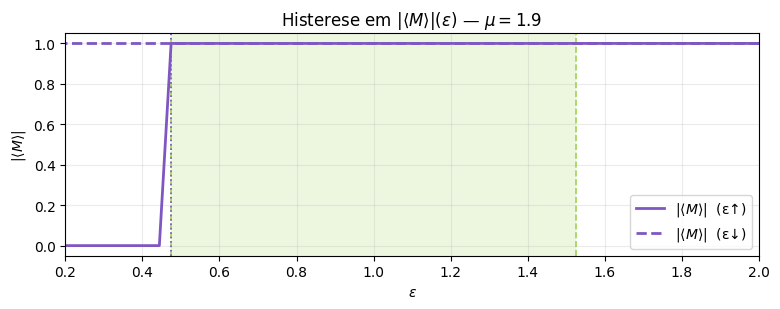

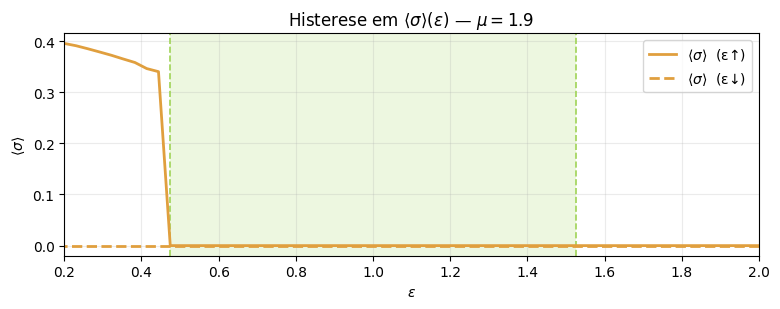

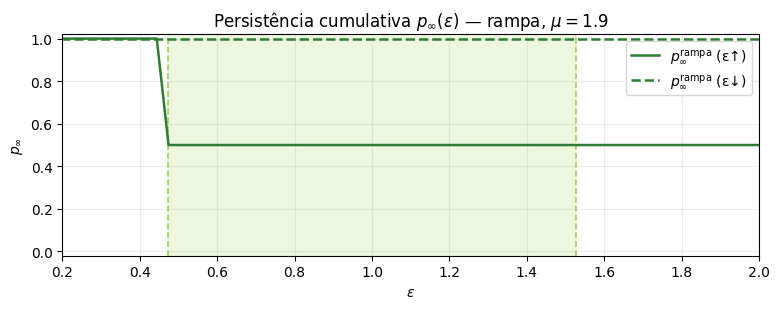

In [18]:
def arrays_from_rows(rows):
    eps  = np.array([r["eps"] for r in rows])
    sbar = np.array([r["sigma_bar"] for r in rows])
    Mbar = np.array([r["M_bar"] for r in rows])
    pacc = np.array([r["p_rampa"] for r in rows])      # << aqui
    xabs = np.array([r["x_final_mean_abs"] for r in rows])
    escf = np.array([r["escaped_frac"] for r in rows])
    return eps, sbar, Mbar, pacc, xabs, escf



epsU, sU, MbarU, pU, xU, eU = arrays_from_rows(rows_up)
epsD, sD, MbarD, pD, xD, eD = arrays_from_rows(rows_dn)

# estimativas simples de ε_c por threshold em |<M>| (pode refinar depois)
def estimate_eps_crit(eps, Mbar, target=0.5):
    # primeira passagem do lado baixo p/ cima
    idx = np.where(Mbar>=target)[0]
    return float(eps[idx[0]]) if idx.size>0 else np.nan

ec_up   = estimate_eps_crit(epsU, MbarU, target=0.5)   # em subida
ec_down = estimate_eps_crit(epsD[::-1], MbarD[::-1], target=0.5)  # em descida (para ler “da esquerda p/ direita”)

print(f"ε_c^up  (|<M>|≈0.5) ~ {ec_up:.4f}")
print(f"ε_c^down(|<M>|≈0.5) ~ {ec_down:.4f}")
print(f"Largura de histerese ~ {abs(ec_up - ec_down):.4f}")

# Fronteiras teóricas (somente referência: sincronização transversal)
eps_sync_inf, eps_sync_sup = sync_boundaries(MU)

# 1) |<M>|(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, MbarU, lw=2.0, color=COL_CURVE_M, label=r"$|\langle M\rangle|$  (ε↑)")
ax.plot(epsD, MbarD, lw=2.0, color=COL_CURVE_M, ls="--", label=r"$|\langle M\rangle|$  (ε↓)")
ax.axvline(ec_up,   color=COL_CURVE_M, ls=":", lw=1.2)
ax.axvline(ec_down, color=COL_CURVE_M, ls=":", lw=1.2)
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M\rangle|$")
ax.set_title(r"Histerese em $|\langle M\rangle|(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_Mbar.png", dpi=220); plt.show()

# 2) <σ>(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, sU, lw=2.0, color=COL_CURVE_SIGMA, label=r"$\langle\sigma\rangle$  (ε↑)")
ax.plot(epsD, sD, lw=2.0, color=COL_CURVE_SIGMA, ls="--", label=r"$\langle\sigma\rangle$  (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$\langle\sigma\rangle$")
ax.set_title(r"Histerese em $\langle\sigma\rangle(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_sigma.png", dpi=220); plt.show()

# 3) Persistência p(ε) 
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, pU, lw=1.8, color=COL_CURVE_P,               label=r"$p_\infty^{\rm rampa}$ (ε↑)")
ax.plot(epsD, pD, lw=1.8, color=COL_CURVE_P, ls="--",      label=r"$p_\infty^{\rm rampa}$ (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX); ax.set_ylim(-0.02, 1.02)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$p_\infty$")
ax.set_title(rf"Persistência cumulativa $p_\infty(\varepsilon)$ — rampa, $\mu={MU}$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_pinf_rampa.png", dpi=220); plt.show()


### Leitura física (ligando com o o que vimos antes - 00–02)

* **Onde exatamente está a transição e fase de 1ª ordem?**

- Diferente do que vimos antes, onde estavamos resetando a condição inicial para cada $\varepsilon$ agora estamos deixando o sistema carregar informação do seu estado no $\varepsilon$ anterior. É essse conbhecimento do sistema sobre seu estado anterior que faz o aparecimentod a histerese, que fica evidente no parâmetrod e ordem.
- A **banda de sincronização** (linhas verdes tracejadas do 00) controla a **estabilidade transversal**; ela **não** fixa sozinha a ordem de fase.
- A **transição de 1ª ordem coletiva** aparece como:
  1) **Histerese** clara entre **ε↑** e **ε↓** nas curvas de $|\langle M\rangle|$ e $\langle\sigma\rangle$;
O que observamos é o fato de que subirmos $\varepsilon$ ou descermos $\varepsilon$ as curvas se ajustam em momentos diferentes, isso é a característica essencial da transição de fase de primeira ordem.
Essa assinatura aparece por exemplo na transição da água, muitos já ouviram falar do ponto anômolo da água entre -4-0ºC, ou até mesmo de congelarmos a cerveja ao sacurdimos a garrafa.
Isso nada mais é do que uma transição de fase de primeira ordem. Resfriando a água ela permanece liquida mesmo já existindo outro mínimo estável (estado congelado). Ao mesmo tempo ao descongelarmos a água ela permanece congelada, mesmo existindo outro mínimo mais estável (estado líquido), de modo que sua transição de fase não possui uma temperatura bem definida. O congelamento ocorre pois fornecemos energia suficiente para as moléculas atravessarem a barreira de potencial e cair no mínimo mais estável - o estado congelado, na cerveja.
  2) **Salto** abrupto de $|\langle M\rangle|$ em ε (discontinuidade) indicam essa transiça~o;
  3) **Bimodalidade** dos histogramas de $x$ perto da comutação (coexistência de bacias $I_\pm$) - Veremos isso a seguir.

**Marcadores práticos neste notebook**
- Estimativas de $\varepsilon_{\rm c}^{\uparrow}$ e $\varepsilon_{\rm c}^{\downarrow}$ (linhas verticais roxas pontilhadas) definem a **largura de histerese**.
- Nos painéis da Parte B, a **coexistência** fica visível (dois picos claros em $x$); ao cruzar $\varepsilon_{\rm c}$, o sistema “colapsa” de um pico para o outro.


In [19]:
# Parâmetros do protocolo (ajuste "modo publicação" vs "rápido")
EPS_MIN, EPS_MAX, NSTEPS = 0.20, 1.4, 60   # cobre fora e dentro da banda (~0.473–1.526)
T_BURN_BLOCK  = 5000
T_MEAS_BLOCK  = 5000
SEED0 = 31415

# IC "half_half" padrão (bacias I±)
cfg0 = Config(N=N, eps=EPS_MIN, mu=MU, seed=SEED0)
sys0 = GloballyCoupledMaps(cfg0); sys0.reset(init="half_half")

eps_up   = np.linspace(EPS_MIN, EPS_MAX, NSTEPS)
eps_down = eps_up[::-1]

def run_branch(sys_start, eps_schedule):
    sys = sys_start
    rows = []

    # Spins de referência no INÍCIO da rampa (para p_rampa)
    s0 = spins(sys.x[None, :])[0]          # shape (N,)
    changed = np.zeros(sys.cfg.N, bool)    # quem já trocou desde t=0 da rampa

    for k, eps in enumerate(eps_schedule):
        # reconfigura ε mantendo o estado
        if k == 0:
            if abs(sys.cfg.eps - eps) > 1e-12:
                sys = reconfigure_system(sys, eps)
        else:
            sys = reconfigure_system(sys, eps)

        # ---- burn-in (conta para p_rampa) ----
        if T_BURN_BLOCK > 0:
            traj_burn = sys.run(T_BURN_BLOCK, track=True)   # (T_burn, N)
            Sb = spins(traj_burn)
            changed |= np.any(Sb != s0, axis=0)

        # ---- janela de medição (conta p/ métricas + p_rampa + p_janela) ----
        traj = sys.run(T_MEAS_BLOCK, track=True)            # (T_meas, N)
        Sm = spins(traj)
        changed |= np.any(Sm != s0, axis=0)

        # métricas na janela (estilo 02)
        sigmas = np.std(traj, axis=1)
        sigma_bar = float(np.mean(sigmas))
        Ms = np.apply_along_axis(magnetization, 1, traj)
        M_bar = float(order_param_M(Ms))

        # persistências
        p_rampa  = float(1.0 - np.mean(changed))      # ACUMULADA (preferida p/ histerese)
        p_janela = float(persistence_curve(Sm)[-1])   # só da janela (referência)

        rows.append({
            "eps": float(eps),
            "sigma_bar": sigma_bar,
            "M_bar": M_bar,
            "p_rampa": p_rampa,               # << usar nos plots
            "p_janela": p_janela,             # opcional para comparar
            "x_final_mean_abs": float(np.mean(np.abs(sys.x))),
            "escaped_frac": float(np.mean(np.abs(sys.x) > 1.0))
        })
    return rows, sys



# Branch ε↑
rows_up, sys_top = run_branch(sys0, eps_up)
# Branch ε↓ (continua do topo — metástabilidade preservada)
rows_dn, sys_end = run_branch(sys_top, eps_down)

# Empacota e salva
res = {"mu": MU, "N": N,
       "eps_up": eps_up.tolist(), "up": rows_up,
       "eps_down": eps_down.tolist(), "down": rows_dn,
       "params": {"T_BURN_BLOCK": T_BURN_BLOCK, "T_MEAS_BLOCK": T_MEAS_BLOCK}}
(DATA/"week3_ramp_mu1.9_2.json").write_text(json.dumps(res, indent=2), encoding="utf-8")


29982

ε_c^up  (|<M>|≈0.5) ~ 0.4847
ε_c^down(|<M>|≈0.5) ~ 0.2000
Largura de histerese ~ 0.2847


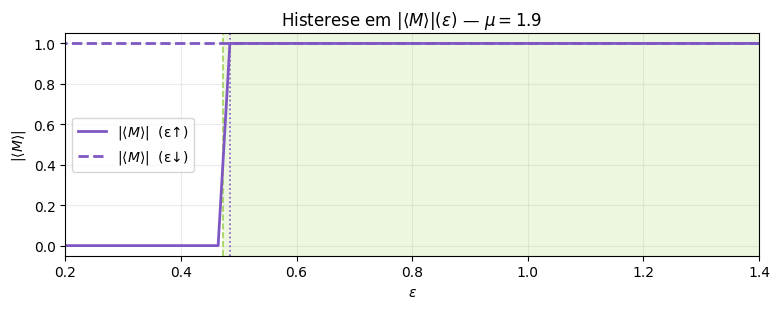

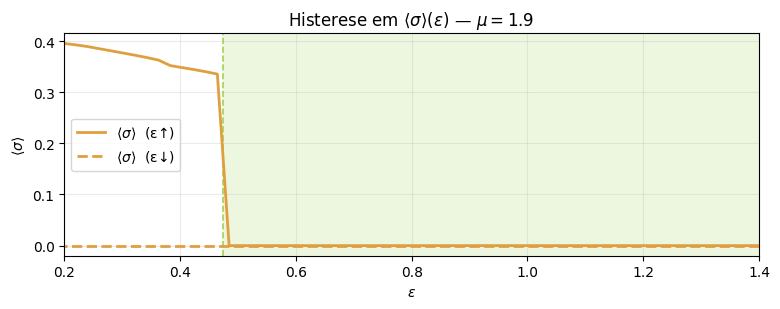

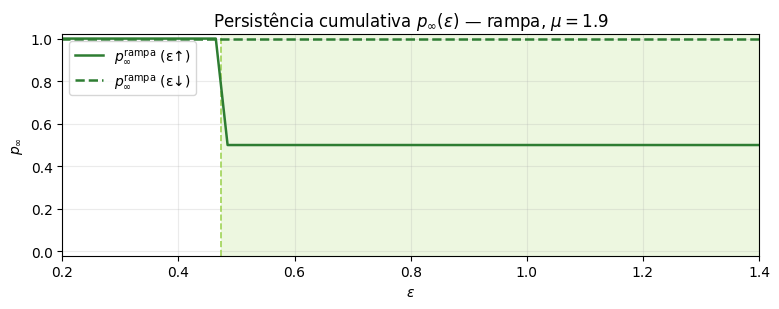

In [20]:
def arrays_from_rows(rows):
    eps  = np.array([r["eps"] for r in rows])
    sbar = np.array([r["sigma_bar"] for r in rows])
    Mbar = np.array([r["M_bar"] for r in rows])
    pacc = np.array([r["p_rampa"] for r in rows])      # << aqui
    xabs = np.array([r["x_final_mean_abs"] for r in rows])
    escf = np.array([r["escaped_frac"] for r in rows])
    return eps, sbar, Mbar, pacc, xabs, escf



epsU, sU, MbarU, pU, xU, eU = arrays_from_rows(rows_up)
epsD, sD, MbarD, pD, xD, eD = arrays_from_rows(rows_dn)

# estimativas simples de ε_c por threshold em |<M>| (pode refinar depois)
def estimate_eps_crit(eps, Mbar, target=0.5):
    # primeira passagem do lado baixo p/ cima
    idx = np.where(Mbar>=target)[0]
    return float(eps[idx[0]]) if idx.size>0 else np.nan

ec_up   = estimate_eps_crit(epsU, MbarU, target=0.5)   # em subida
ec_down = estimate_eps_crit(epsD[::-1], MbarD[::-1], target=0.5)  # em descida (para ler “da esquerda p/ direita”)

print(f"ε_c^up  (|<M>|≈0.5) ~ {ec_up:.4f}")
print(f"ε_c^down(|<M>|≈0.5) ~ {ec_down:.4f}")
print(f"Largura de histerese ~ {abs(ec_up - ec_down):.4f}")

# Fronteiras teóricas (somente referência: sincronização transversal)
eps_sync_inf, eps_sync_sup = sync_boundaries(MU)

# 1) |<M>|(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, MbarU, lw=2.0, color=COL_CURVE_M, label=r"$|\langle M\rangle|$  (ε↑)")
ax.plot(epsD, MbarD, lw=2.0, color=COL_CURVE_M, ls="--", label=r"$|\langle M\rangle|$  (ε↓)")
ax.axvline(ec_up,   color=COL_CURVE_M, ls=":", lw=1.2)
ax.axvline(ec_down, color=COL_CURVE_M, ls=":", lw=1.2)
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$|\langle M\rangle|$")
ax.set_title(r"Histerese em $|\langle M\rangle|(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_Mbar.png", dpi=220); plt.show()

# 2) <σ>(ε)
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, sU, lw=2.0, color=COL_CURVE_SIGMA, label=r"$\langle\sigma\rangle$  (ε↑)")
ax.plot(epsD, sD, lw=2.0, color=COL_CURVE_SIGMA, ls="--", label=r"$\langle\sigma\rangle$  (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$\langle\sigma\rangle$")
ax.set_title(r"Histerese em $\langle\sigma\rangle(\varepsilon)$ — $\mu=1.9$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_hysteresis_sigma.png", dpi=220); plt.show()

# 3) Persistência p(ε) 
fig, ax = plt.subplots(figsize=(7.9,3.2))
shade_sync_band(ax, MU, COL_SYNC_CHAOS, alpha=0.18)
ax.plot(epsU, pU, lw=1.8, color=COL_CURVE_P,               label=r"$p_\infty^{\rm rampa}$ (ε↑)")
ax.plot(epsD, pD, lw=1.8, color=COL_CURVE_P, ls="--",      label=r"$p_\infty^{\rm rampa}$ (ε↓)")
ax.set_xlim(EPS_MIN, EPS_MAX); ax.set_ylim(-0.02, 1.02)
ax.set_xlabel(r"$\varepsilon$"); ax.set_ylabel(r"$p_\infty$")
ax.set_title(rf"Persistência cumulativa $p_\infty(\varepsilon)$ — rampa, $\mu={MU}$")
ax.grid(alpha=0.25); ax.legend(loc="best")
fig.tight_layout(); fig.savefig(FIGS/"03_pinf_rampa_2.png", dpi=220); plt.show()


## Parte B - Histogramas perto da comutação (coexistência de fases)

ε selecionados para histogramas: [0.2        0.22033898 0.46440678 0.48474576]


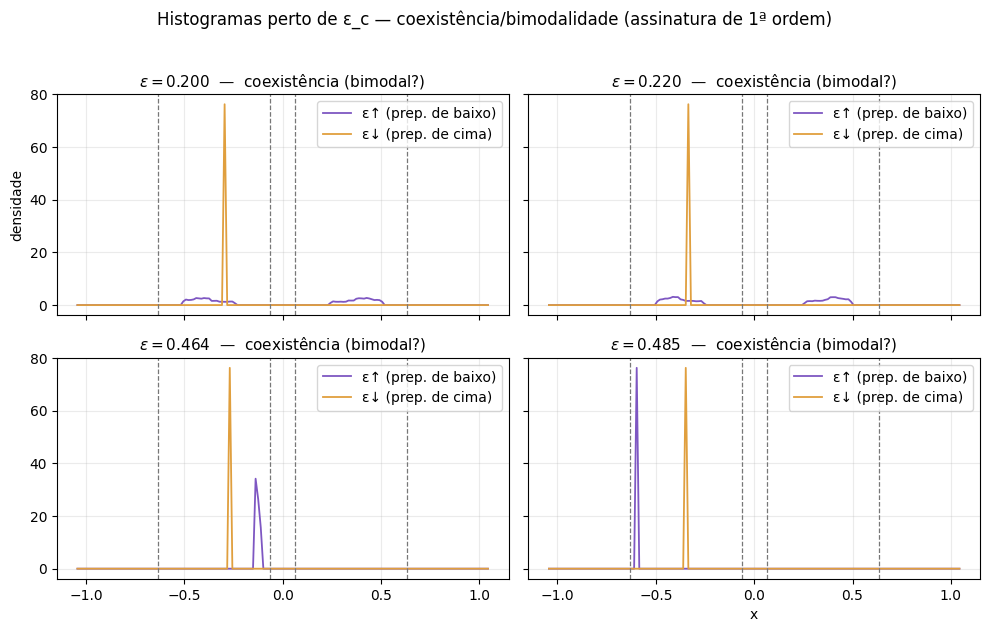

31089

In [21]:
# Escolhe 4 ε próximos de ec_up e ec_down para ilustrar coexistência
def pick_near(values, center, k=2):
    arr = np.array(values)
    idx = np.argsort(np.abs(arr - center))[:k]
    return np.sort(arr[idx])

eps_show = np.unique(np.concatenate([
    pick_near(epsU, ec_up, k=2),
    pick_near(epsD, ec_down, k=2)
]))

print("ε selecionados para histogramas:", eps_show)

# Para cada ε desses, roda uma janela longa a partir do estado 'metastável' adequado
# Estratégia: "preparar" subindo até mais próximo (para ε acima) e descendo até mais próximo (para ε abaixo)
def prepare_state_to_eps(eps_target, mode="up", seed=999):
    # começa em uma extremidade, faz ramp rápida até o alvo (mantendo estado)
    eps_path = np.linspace(EPS_MIN if mode=="up" else EPS_MAX, eps_target, 8)
    sys = GloballyCoupledMaps(Config(N=N, eps=eps_path[0], mu=MU, seed=seed))
    sys.reset(init="half_half")
    for e in eps_path[1:]:
        sys = reconfigure_system(sys, e)
        sys.run(400, track=False)
    return sys

hist_data = {}
BINS = 160
for e in eps_show:
    # prepara por dois lados para evidenciar bacias distintas (se houver)
    sysU = prepare_state_to_eps(e, mode="up",   seed=20231)   # vindo de baixo (ε↑)
    sysD = prepare_state_to_eps(e, mode="down", seed=20232)  # vindo de cima (ε↓)

    # mede em cada preparo
    def sample_hist(sys):
        sys.run(1200, track=False)
        xs = sys.x.copy()
        hist, edges = np.histogram(xs, bins=BINS, range=(-1.05, 1.05), density=True)
        centers = 0.5*(edges[:-1] + edges[1:])
        return centers, hist

    cU, hU = sample_hist(sysU)
    cD, hD = sample_hist(sysD)
    hist_data[float(e)] = {"centers": cU.tolist(), "hist_up": hU.tolist(), "hist_down": hD.tolist()}

# Plota 2x2 (até 4 valores)
m = min(4, len(eps_show))
rows = int(np.ceil(m/2)); cols = 2 if m>1 else 1
fig, axes = plt.subplots(rows, cols, figsize=(10, 3.2*rows), sharex=True, sharey=True)
axes = np.atleast_1d(axes).ravel()

for ax, e in zip(axes, eps_show[:m]):
    d = hist_data[float(e)]
    ax.plot(d["centers"], d["hist_up"],   lw=1.3, color=COL_CURVE_M,     label="ε↑ (prep. de baixo)")
    ax.plot(d["centers"], d["hist_down"], lw=1.3, color=COL_CURVE_SIGMA, label="ε↓ (prep. de cima)")
    # marca I±
    i_minus, i_plus = bistable_intervals(MU)
    for xv in [i_minus[0], i_minus[1], i_plus[0], i_plus[1]]:
        ax.axvline(xv, color="#777777", lw=0.9, ls="--")
    ax.set_title(rf"$\varepsilon={e:.3f}$  —  coexistência (bimodal?)", fontsize=11)
    ax.grid(alpha=0.25); ax.legend(loc="best")

axes[-1].set_xlabel("x"); axes[0].set_ylabel("densidade")
fig.suptitle("Histogramas perto de ε_c — coexistência/bimodalidade (assinatura de 1ª ordem)", y=0.98)
fig.tight_layout(rect=[0,0,1,0.96]); fig.savefig(FIGS/"03_hist_coexistencia.png", dpi=220); plt.show()

# Salva em JSON
(DATA/"03_hist_coexistencia.json").write_text(json.dumps(hist_data, indent=2), encoding="utf-8")


**Interpretação do gráfico:**
- O que obsevamos acima essencialmente é o seguinte fato: dependendo da forma que você varia $\varepsilon$ (equivalente a temperatura na analogia da água) chegamos no mesmo $\varepsilon$ a configurações diferentes do mesmo sistema físico. Ou seja, mantendo o mesmo mapa local e alterando a influência da sua globalidade observamos a quebra de simetria. É claro que isso também está associado ao fato de termos bimalidade - dois estados possíveis acessíveis do sistema.
- **Histerese marcante** em $|\langle M\rangle|$ e $\langle\sigma\rangle$: as curvas de ε↑ e ε↓ **não coincidem**.
- **Saltos** em $|\langle M\rangle|$ localizam $\varepsilon_{\rm c}^{\uparrow,\downarrow}$; a diferença define a **largura de histerese**.
- **Coexistência de bacias** (bimodalidade) perto de ε\_c, confirmando o **caráter de 1ª ordem**.
- A banda de **sincronização transversal** (do 00) explica **onde** a variedade sincronizada é estável; já a **ordem de fase** (audiência $I_+$ vs $I_-$) mostra **saltos** e **metástase** (1ª ordem) sob variação de ε.
